<a href="https://colab.research.google.com/github/ratulbempu/ApneBoot-Clinical-Data-Analysis/blob/main/230301%20-%20AB%20Clinical%20Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

22-07-23 - I updated it so it loads logs and creates df_s and df_d faster. Also includes Log Source File. Works for Zug, need to check for nonin. 
Actual and Preset are slightly different because:
- Preset mode number shows up at the start of the apnea, Stim shows at start of stim +1 (instead of 5s it looks like 6 sec+1. This may be a rounding issue. Would be nice if they were on the same line but ok. 
- This rounding issue may also cause different apnea stimulation lengths by a second or two.


22-09-03 - 
- Added code to convert table to pdf

22-09-10 -
- Fix Smoothing Issue
- Add Thresholds 

22-19-18
Todo:
- X make individual plots ouput to pdf
- X - Good Enough - make summary table cleaner
  - reduce number of columns
  - increase overall font size
- X test with custom thresholds
- test and fix for nonin
- combine relevent pdfs into a report.
- test with Clinical Data

23-03-01
- want table with name, total time monitored, total time below X condition calculated), total stimulations, total stimulation time, total time under Y condition, total errorenous data. 
 



## **Initialize**

### Set Folder Name

### Import and Find Folders

In [5]:
#@title
import fileinput
import glob
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import os
import linecache
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
!pip install ipython-autotime
%load_ext autotime

%matplotlib inline
print ("Imports done")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Imports done
time: 2.07 ms (started: 2023-03-15 05:27:18 +00:00)


In [6]:
#@title
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.83 s (started: 2023-03-15 05:27:18 +00:00)


### Get Folders List

In [7]:
#@title
import os

def list_folders(startpath):
    list_path = []
    list_folder = []
    log = "log"
    LOG = "LOG"
    is_data_dir = 0;
    previous_name_path = ""
    for root, subdirs, files in os.walk(startpath):
        is_data_dir = 0
        for filename in files:
            current_name_path = os.path.join(root)
            if ((log in filename) | (LOG in filename)) & (previous_name_path != current_name_path):
                full_path = os.path.join(root,filename)
                list_folder.insert (0, os.path.basename (current_name_path))
                list_path.insert(0, root)
                previous_name_path = current_name_path

    return list_path, list_folder


time: 3.54 ms (started: 2023-03-15 05:27:20 +00:00)


### Import and Initialize Folders

## **Convert Files to Data Frames**

### Headers for Different Logger Versions

In [8]:
#@title

header = ""
settings_header = "" 
AB_Model = "default_string"
number_of_commas = 0


def decideDataLoggerVersion (df):
  # Read the third line's header and decide which data logger version is used
  # Assumes that the third line is unique for each data logger version
  # I need to check with Sourabh if the third line correlates with versions for the St. John's studies.
  global header
  global settings_header
  global AB_Model
  global number_of_commas
  
  raw_logfile_data_table_headers = ["default"]
  settings_table_headers = [""]
  data_table_headers = [""]
  settings_columns_rename_dict = [""]
  settings_columns_to_drop = [""]
  version = "unknown data code version"

  ZUG_DATA_HEADER = "dd/mm/yy,hh:mm:ss,SPO2,HR,PI,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Battery voltage;"
  NONIN_DATA_HEADER = "dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage"
  CLINICAL_SETTINGS_HEADER_INTERVENTION = "dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;"
  CLINICAL_SETTINGS_HEADER_PLACEBO = "dd/mm/yy,hh:mm:ss,Placebo,Stimulator Intensity,Alarm intensity;"

  settings_header = df.iat[0,0]
  header = df.iat[2,0]
  number_of_commas = header.count (',')
  print (settings_header)
  print (header)

  if header == ZUG_DATA_HEADER:
    version = "ZUG Circa April 2022"
    # print ("Detected Zug")
  elif (header == NONIN_DATA_HEADER):
      if (settings_header == CLINICAL_SETTINGS_HEADER_INTERVENTION):
          version = "Clinical M3-Intervention (Nonin) 2019"
          AB_Model = "M3-Intervention"
      elif (settings_header == CLINICAL_SETTINGS_HEADER_PLACEBO):
          version = "Clinical M3-Placebo (Nonin) 2019"
          AB_Model = "M3-Placebo"
      else:
          version = "NONIN Circa April 2022"
    # print ("Detected Nonin")
  elif number_of_commas == 5:
      version = "Clinical M1 (Nonin, Tuhin) 2019"
      AB_Model = "M1"
  elif number_of_commas == 9:
      version = "Clinical M2 (Nonin, Satish) 2019"
      AB_Model = "M2"
  else:
    print ("Not able to Detect Nonin Nor Zug")
    AB_Model = "Unable to detect AB Model"
  
  print (version)

  if version == "ZUG Circa April 2022":
    AB_Model = "ZUG Circa April 2022"
    raw_logfile_data_table_headers = [#"Settings Index",
                          #"Data Date-Time",
                           "Data Date",
             "Data Time",
            "SPO2",
            "HR",
            "PI",
            "Status",
            "Pulse-ox mode",
            "Threshold Met",
            "Stimulator Error",
            "Stimulator ON/OFF",
            "Power Mode",
        #     "Probe Off patient", - July 22, 2022 - RN checked this with Sourabh - this value was not being recorded although it is in the header
            "Battery voltage",
            #"Settings Index" # This is added at the end and is blank until filled
            ]
    data_table_headers = ["Settings Index",
                "Data Date-Time",
                "Data Date",
                "Data Time",
                "SPO2",
                "HR",
                "PI",
                "Status",
                "Pulse-ox mode",
                "Threshold Met",
                "Stimulator Error",
                "Stimulator ON/OFF",
               "Power Mode",   
            #   "Probe Off patient",
                "Battery voltage"
                ]
    settings_table_headers = [#'Settings Date-Time'
                              'Settings Index',
                                  'Settings Date',
                'Settings Time',
                'Preset mode',
                'SPO2 Threshold',
                "HR Threshold",
                "AND/OR",
                "Duration",
                "Stimulator Intensity",
                "Alarm intensity"]

    data_convert_dict = {
#                "Settings Index": int,
                "Data Date-Time": 'datetime64[ns]',
                "Data Date": 'datetime64[ns]',
                "Data Time": 'datetime64[ns]',
                "SPO2": int,
                "HR": int,
                "PI": float,
                "Status": int,
                "Pulse-ox mode":int,
                "Threshold Met":int,
                "Stimulator Error":int,
                "Stimulator ON/OFF":int,
                "Power Mode":int,
            #     "Probe Off patient":int,
                "Battery voltage": float
                #,"Settings Index": int
                }

    settings_convert_dict = {
#                "Settings Index": int,
                "Settings Date-Time": str,
                "Settings Date": str,
                'Settings Time':str,
                'Preset mode':int,
                'SPO2 Threshold':int,
                "HR Threshold":int,
                "AND/OR":int,
                "Duration":int,
                "Stimulator Intensity":int,
                "Alarm intensity":str}
    settings_columns_rename_dict = {
             "Data Date":"Settings Date",
             "Data Time": "Settings Time",
            "SPO2":"Preset mode",
            "HR":"SPO2 Threshold",
            "PI":"HR Threshold",
            "Status":"AND/OR",
            "Pulse-ox mode":"Duration",
            "Threshold Met":"Stimulator Intensity",
            "Stimulator Error":"Alarm intensity"
        #     "Stimulator ON/OFF",
        #     "Power Mode",
        # #     "Probe Off patient",
        #     "Battery voltage",
        #     "Settings Index" # This is added at the end and is blank until filled
        }
    
    settings_columns_to_drop = ["Stimulator ON/OFF",
           "Power Mode",
            "Battery voltage"]

  if version == "NONIN Circa April 2022":
    AB_Model = "NONIN Circa April 2022"
    raw_logfile_data_table_headers = [#"Settings Index",
                          #"Data Date-Time",
                           "Data Date",
             "Data Time",
            "SPO2",
            "HR",
         #   "PI",
            "Status",
            "Pulse-ox mode",
            "Threshold Met",
            "Stimulator Error",
            "Stimulator ON/OFF",
            "Power Mode",
        #     "Probe Off patient", - July 22, 2022 - RN checked this with Sourabh - this value was not being recorded although it is in the header
            "Battery voltage",
            "Extra Column"
            #"Settings Index" # This is added at the end and is blank until filled
            ]
    data_table_headers = ["Settings Index",
                "Data Date-Time",
                "Data Date",
                "Data Time",
                "SPO2",
                "HR",
          #      "PI",
                "Status",
                "Pulse-ox mode",
                "Threshold Met",
                "Stimulator Error",
                "Stimulator ON/OFF",
               "Power Mode",
            #   "Probe Off patient",
                "Battery voltage"
                ]
    settings_table_headers = [#'Settings Date-Time'
                              'Settings Index',
                                  'Settings Date',
                'Settings Time',
                'Preset mode',
                'SPO2 Threshold',
                "HR Threshold",
                "AND/OR",
                "Duration",
                "Stimulator Intensity",
                "Alarm intensity"]

    data_convert_dict = {
                #"Settings Index": int,
                # "Data Date-Time": 'datetime64[ns]',
                # "Data Date": 'datetime64[ns]',
                # "Data Time": 'datetime64[ns]',
                "SPO2": int,
                "HR": int,
           #     "PI": float,
                "Status": int,
                "Pulse-ox mode":int,
                "Threshold Met":int,
                "Stimulator Error":int,
                "Stimulator ON/OFF":int,
                "Power Mode":int,
            #     "Probe Off patient":int,
                "Battery voltage": float}
                #"Settings Index": int}

    settings_convert_dict = {
                # "Settings Date-Time": 'datetime64[ns]',
                # "Settings Date": 'datetime64[ns]',
                # 'Settings Time':'datetime64[ns]',
                'Preset mode':int,
                'SPO2 Threshold':int,
                "HR Threshold":int,
                "AND/OR":int,
                "Duration":int,
                "Stimulator Intensity":int,
                "Alarm intensity":str
                #"Settings Index": int
                }
    settings_columns_rename_dict = {

             "Data Date":"Settings Date",
             "Data Time": "Settings Time",
            "SPO2":"Preset mode",
            "HR":"SPO2 Threshold",
            "Status":"HR Threshold",
            "Pulse-ox mode":"AND/OR",
            "Threshold Met":"Duration",
            "Stimulator Error":"Stimulator Intensity",
            "Stimulator ON/OFF":"Alarm intensity"
        #     "Stimulator ON/OFF",
        #     "Power Mode",
        # #     "Probe Off patient",
        #     "Battery voltage",
        #     "Settings Index" # This is added at the end and is blank until filled
        }
    settings_columns_to_drop = [
           "Power Mode",
            "Battery voltage",
            "Extra Column"]

#   elif number_of_commas == 5:
#       version = "Nonin Clinical Study Model 2019"

  if version == "Clinical M1 (Nonin, Tuhin) 2019":

    raw_logfile_data_table_headers = [
                           "Data Date",
             "Data Time",
            "Status",
            "HR",
            "SPO2",
            "Stimulator ON/OFF",
            ]
    data_table_headers = ["Settings Index",
                "Data Date-Time",
                "Data Date",
                "Data Time",
                "Status",
                "HR",
                "SPO2",
          #      "PI",
                
                "Pulse-ox mode",
                "Threshold Met",
                "Stimulator Error",
                "Stimulator ON/OFF",
               "Power Mode",
            #   "Probe Off patient",
                "Battery voltage"
                ]
    settings_table_headers = [#'Settings Date-Time'
                              'Settings Index',
                                  'Settings Date',
                'Settings Time',
                'Preset mode',
                'SPO2 Threshold',
                "HR Threshold",
                "AND/OR",
                "Duration",
                "Stimulator Intensity",
                "Alarm intensity"]

    data_convert_dict = {
                #"Settings Index": int,
                # "Data Date-Time": 'datetime64[ns]',
                # "Data Date": 'datetime64[ns]',
                # "Data Time": 'datetime64[ns]',
                "SPO2": int,
                "HR": int,
           #     "PI": float,
                "Status": int,
            #     "Pulse-ox mode":int,
            #     "Threshold Met":int,
            #     "Stimulator Error":int,
                "Stimulator ON/OFF":int
            #     "Power Mode":int,
            # #     "Probe Off patient":int,
            #     "Battery voltage": float}
                #"Settings Index": int
                }

    settings_convert_dict = {
                # "Settings Date-Time": 'datetime64[ns]',
                # "Settings Date": 'datetime64[ns]',
                # 'Settings Time':'datetime64[ns]',
                # 'Preset mode':int,
                # 'SPO2 Threshold':int,
                # "HR Threshold":int,
                # "AND/OR":int,
                # "Duration":int,
                # "Stimulator Intensity":int
                # "Alarm intensity":str
                #"Settings Index": int
                }
    settings_columns_rename_dict = {

             "Data Date":"Settings Date",
             "Data Time": "Settings Time",
            # "Stimulator ON/OFF",
            # "Power Mode",
        #     "Probe Off patient",
            # "Battery voltage",
            # "Settings Index" # This is added at the end and is blank until filled
        }
    settings_columns_to_drop = [    
                    "Status",
            "HR",
            "SPO2",
            "Stimulator ON/OFF",        

            ]


  if version == "Clinical M2 (Nonin, Satish) 2019":
    raw_logfile_data_table_headers = [
                           "Data Date",
             "Data Time",
            "HR",
            "SPO2",
            "Status",
            "Unused Column 1",
            "Unused Column 2",
            "Unused Column 3",
            "Stimulator ON/OFF",
            "Unused Column 4",
             # <-- need to double check which column is stim off/on
            ]
    data_table_headers = ["Settings Index",
                "Data Date-Time",
                "Data Date",
                "Data Time",
                "HR",
                "SPO2",
          #      "PI",
                "Status",
                "Pulse-ox mode",
                "Threshold Met",
                "Stimulator Error",
                "Stimulator ON/OFF",
               "Power Mode",
            #   "Probe Off patient",
                "Battery voltage"
                ]
    settings_table_headers = [#'Settings Date-Time'
                              'Settings Index',
                                  'Settings Date',
                'Settings Time',
                'Preset mode',
                'SPO2 Threshold',
                "HR Threshold",
                "AND/OR",
                "Duration",
                "Stimulator Intensity",
                "Alarm intensity"]

    data_convert_dict = {
                #"Settings Index": int,
                # "Data Date-Time": 'datetime64[ns]',
                # "Data Date": 'datetime64[ns]',
                # "Data Time": 'datetime64[ns]',
                "SPO2": int,
                "HR": int,
           #     "PI": float,
                "Status": int,
            #     "Pulse-ox mode":int,
            #     "Threshold Met":int,
            #     "Stimulator Error":int,
                "Stimulator ON/OFF":int
            #     "Power Mode":int,
            # #     "Probe Off patient":int,
            #     "Battery voltage": float}
                #"Settings Index": int
                }

    settings_convert_dict = {
                # "Settings Date-Time": 'datetime64[ns]',
                # "Settings Date": 'datetime64[ns]',
                # 'Settings Time':'datetime64[ns]',
                # 'Preset mode':int,
                # 'SPO2 Threshold':int,
                # "HR Threshold":int,
                # "AND/OR":int,
                # "Duration":int,
                # "Stimulator Intensity":int
                # "Alarm intensity":str
                #"Settings Index": int
                }
    settings_columns_rename_dict = {

             "Data Date":"Settings Date",
             "Data Time": "Settings Time",
            # "Stimulator ON/OFF",
            # "Power Mode",
        #     "Probe Off patient",
            # "Battery voltage",
            # "Settings Index" # This is added at the end and is blank until filled
        }
    settings_columns_to_drop = [            
        "HR",	"SPO2",	"Status","Stimulator ON/OFF",
        "Unused Column 1",
            "Unused Column 2",
            "Unused Column 3",
            "Unused Column 4",
            ]

################ M3 ###########
  if ((version == "Clinical M3-Intervention (Nonin) 2019") | (version == "Clinical M3-Placebo (Nonin) 2019")):
  
    raw_logfile_data_table_headers = [#"Settings Index",
                          #"Data Date-Time",
                           "Data Date",
             "Data Time",
            "SPO2",
            "HR",
         #   "PI",
            "Status",
            "Pulse-ox mode",
            "Threshold Met",
            "Stimulator Error",
            "Stimulator ON/OFF",
            "Power Mode",
            "Probe Off patient", # clinical version has this column matching up, not sure if it is actually recording the correct data though
            "Battery voltage",
            ]
    data_table_headers = ["Settings Index",
                "Data Date-Time",
                "Data Date",
                "Data Time",
                "SPO2",
                "HR",
          #      "PI",
                "Status",
                "Pulse-ox mode",
                "Threshold Met",
                "Stimulator Error",
                "Stimulator ON/OFF",
               "Power Mode",
            #   "Probe Off patient",
                "Battery voltage"
                ]
    settings_table_headers = [#'Settings Date-Time'
                              'Settings Index',
                                  'Settings Date',
                'Settings Time',
                'Preset mode',
                'SPO2 Threshold',
                "HR Threshold",
                "AND/OR",
                "Duration",
                "Stimulator Intensity",
                "Alarm intensity"]

    data_convert_dict = {
                #"Settings Index": int,
                # "Data Date-Time": 'datetime64[ns]',
                # "Data Date": 'datetime64[ns]',
                # "Data Time": 'datetime64[ns]',
                "SPO2": int,
                "HR": int,
           #     "PI": float,
                "Status": int,
                "Pulse-ox mode":int,
                "Threshold Met":int,
                "Stimulator Error":int,
                "Stimulator ON/OFF":int,
                "Power Mode":int,
            #     "Probe Off patient":int,
                "Battery voltage": float}
                #"Settings Index": int}

    settings_convert_dict = {

                "Stimulator Intensity":int,
                "Alarm intensity":str
                #"Settings Index": int
                }
    ## Settings rename dictionary is different 
    settings_columns_rename_dict = {
             "Data Date":"Settings Date",
             "Data Time": "Settings Time",
            "SPO2":"Intervention or Placebo", 
            "HR" : "Stimulator Intensity",
            "Status":"Alarm intensity",
        }
    settings_columns_to_drop = [
            "Pulse-ox mode",
            "Threshold Met",
            "Stimulator Error",
            "Stimulator ON/OFF",
            "Power Mode",
            "Probe Off patient", # clinical version has this column matching up, not sure if it is actually recording the correct data though
            "Battery voltage",
]

#   elif number_of_commas == 5:
#       version = "Nonin Clinical Study Model 2019"


  return raw_logfile_data_table_headers, settings_table_headers, data_table_headers, settings_columns_rename_dict, settings_columns_to_drop, settings_convert_dict, data_convert_dict

time: 11.4 ms (started: 2023-03-15 05:27:20 +00:00)


### Compile & Split Log Files to df_d and df_s

In [9]:
#@title
# Reference here: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
file_list = []

def compileLogFiles (path):
  global file_list
#   print (path)
  os.chdir(path)
  file_list = sorted(glob.glob("*LOG*.csv")) + sorted(glob.glob("*log*.csv")) + sorted(glob.glob("*Log*.csv")) + sorted(glob.glob("*LOG*.txt")) + sorted(glob.glob("*log*.txt")) + sorted(glob.glob("*Log*.txt")) + sorted(glob.glob("*LOG*.TXT")) + sorted(glob.glob("*log*.TXT")) + sorted(glob.glob("*Log*.TXT"))
              # in 2019 clinical, some files are log and some are LOG
#   file_list = sorted(glob.glob("*"))
  number_of_files = len(file_list)
#   print("Number of Files:" , len(file_list))
  print (file_list)
  li = []

  for file_name in file_list:
    # This could work faster potentially, but then the data logger identifier code for finding the zug/nonin code string has to be changed
    # df = pd.read_csv(file_name, header=None, sep='\n', names=list(range(12)))
    
    # df = pd.read_csv(file_name, header=None)
    df = pd.read_csv(file_name, header=None, sep='\0')
    # df = pd.read_csv(file_name, header=None, sep='\n')
    # df = pd.read_csv(file_name, header=None, sep=',')
    df['Source File'] = file_name
    li.append (df)
  
  frame = pd.concat(li, axis=0, ignore_index=True)
  return frame


time: 3.13 ms (started: 2023-03-15 05:27:20 +00:00)


In [10]:
#@title
def splitToDataAndSettingsDF (df_LOGs):
  
  raw_logfile_data_table_headers, settings_table_headers, data_table_headers, settings_columns_rename_dict, settings_columns_to_drop, settings_convert_dict, data_convert_dict = decideDataLoggerVersion (df_LOGs)    

  df_raw = df_LOGs[0].str.split(',', expand=True)
  #display (df_raw)
   
  df_raw.columns = raw_logfile_data_table_headers
  df_raw["Source File"] = df_LOGs ["Source File"]

  # Extract Settings
  df_raw_shift = df_raw.shift(periods=-1)
  df_s = df_raw_shift[(df_raw.iloc[:,2]=="Preset mode") | (df_raw.iloc[:,2]=="Intervention") | (df_raw.iloc[:,2]=="Placebo")]
  # For the clinical data - just use the rows with a new source file to keep the time/date and file. 
  if ((AB_Model == "M1") | (AB_Model == 'M2')):
    df_s = df_raw.drop_duplicates(subset=["Source File"], keep='first')


  # Delete settings and settings headers
  df_raw_shift = df_raw.shift(periods=1)                                        #shift down one row as a way to find one line below the settings header
  rows_below_header = df_raw[(df_raw_shift.iloc[:,2]=="Preset mode") |(df_raw_shift.iloc[:,2]=="Intervention")|(df_raw_shift.iloc[:,2]=="Placebo")]
  df_raw = df_raw.drop(rows_below_header.index)                                 #Drop all the setttings data lines 
  rows_with_header = df_raw[(df_raw.iloc[:,2]=="Preset mode") |(df_raw.iloc[:,2]=="Intervention")|(df_raw.iloc[:,2]=="Placebo")]
  df_raw = df_raw.drop (rows_with_header.index)                                 #Drops all the settings headers
  rows_with_header = df_raw[df_raw.iloc[:,2]=="SPO2"]
  df_raw = df_raw.drop (rows_with_header.index)                                 #Drops all the DATA headers
  
  # Format Settings Files
  df_s.drop(settings_columns_to_drop, axis=1, inplace=True)                     # Drop extra columns
  df_s.rename(columns=settings_columns_rename_dict, inplace=True)
  if 'Alarm Intensity' in df_s.columns:
    df_s['Alarm intensity'].apply(lambda v: v.rstrip(';'))
  
  #What's left of df_raw is now df_d for data
  df_d = df_raw
  if (AB_Model == "NONIN Circa April 2022"):
    df_d.drop (columns = "Extra Column", axis = 1, inplace=True)
    #df_s.drop (columns = "Extra Column", axis = 1, inplace=True)

  # In the clinical, Tuhin put P for the devices that were placebo and would have stimulated but actually didn't.
  # Replace those with the number 1
  df_d["Stimulator ON/OFF"].mask(df_d["Stimulator ON/OFF"] == " P", 1, inplace= True)
  

  
  
  if (AB_Model == "M1"):
    format_day = '%d-%MM-%yyyy'
    format_time = '%H:%m:%s'
  else:
    format_day = '%d/%m/%y'
    format_time = '%H:%M:%S'
    

#   if (AB_Model == "M1"):
#       try:
#         display (df_s)
#         display (df_d)
#         # df_s.head()
#         # df_d.head()
        
#         # print (df_d.columns)
#         # print ("df_s1 " + df_s["Settings Date"][3] + df_s["Settings Time"][3])
#         df_s.insert(loc=0, column="Settings Date-Time", value=pd.to_datetime(df_s["Settings Date"] + df_s["Settings Time"] ,format='%d-%MM-%yyyy %H:%m:%s'))
#         print ("df_d1 " + df_d["Data Date"][3] + df_d["Data Time"][3])
#         df_d.insert(loc=0, column="Data Date-Time", value=pd.to_datetime(df_d["Data Date"] + df_d["Data Time"] ,format='%d-%MM-%yyyy %H:%m:%s'))   
#         print ("matched 1!")
#       except Exception as e:
#           print (e)
#           print ("try alternate date format:")
#           display (df_s)
#         #   print (df_d.columns)
#           try:
#             # df_s.drop ("Settings Date-Time")
#             # df_d.drop ("Data Date-Time")
#             # df_s.insert(loc=0, column="Settings Date-Time", value=pd.to_datetime(df_s["Settings Date"] + df_s["Settings Time"] ,format='%d/%M/%yyyy %H:%m:%s'))
#             # df_d.insert(loc=0, column="Data Date-Time", value=pd.to_datetime(df_d["Data Date"] + df_d["Data Time"] ,format='%d/%M/%yyyy %H:%m:%s'))  
#             print ("matched 2!")
#           except Exception as e2:
#             print (e2)
#             print ("no more date formats to try!")       
 

#   else:
#     df_s.insert(loc=0, column="Settings Date-Time", value=pd.to_datetime(df_s["Settings Date"] + ' ' + df_s["Settings Time"] ,format='%d/%m/%y %H:%M:%S'))
#     df_d.insert(loc=0, column="Data Date-Time", value=pd.to_datetime(df_d["Data Date"] + ' ' + df_d["Data Time"] ,format='%d/%m/%y %H:%M:%S'))
#   print ("inserting with "+format_day + " " + format_time)
#   display (df_s)

#   print ("df_s insert done, here's what it looks like")
#   display (df_s)
#   display (df_d)

#   print ("df_d coerce done and now df_d looks like:")
#   display (df_d)
#   print ("inserts done")

# MARCH 9, 2023 - These two lines below work (infer_datetime_format=True needs to be checked bc some columns may have multiple date Time formats?) 
# but it's still slow so I'm commenting them out for now and replacing them with the two below

#   df_s.insert(loc=0, column="Settings Date-Time", value=pd.to_datetime(df_s["Settings Date"] + ' ' + df_s["Settings Time"], infer_datetime_format = True, errors = 'coerce'))
#   df_d.insert(loc=0, column="Data Date-Time", value=pd.to_datetime(df_d["Data Date"] + ' ' + df_d["Data Time"], infer_datetime_format = True, errors = 'coerce'))

  df_s.insert(loc=0, column="Settings Date-Time", value=df_s["Settings Date"] + ' ' + df_s["Settings Time"])
  df_d.insert(loc=0, column="Data Date-Time", value=df_d["Data Date"] + ' ' + df_d["Data Time"])



  if ((AB_Model == "M1") | (AB_Model == "M2") | (AB_Model == "M3-Placebo") | (AB_Model == "M3-Intervention")):
      df_s.insert(loc = 3, column="Preset mode", value = 1)
      df_s.insert(loc = 4, column="SPO2 Threshold", value = 0)
      df_s.insert(loc = 5, column="HR Threshold", value = 0)
      df_s.insert(loc = 6, column="AND/OR", value = 0)
      df_s.insert(loc = 7, column="Duration", value = 0)
      if ((AB_Model == "M1") | (AB_Model == "M2")):
        df_s.insert(loc = 8, column="Stimulator Intensity", value = 0)
        df_s.insert(loc = 9, column="Alarm intensity", value = 0)

  #Cleanup NaNs
  df_d = df_d.fillna(0)
  df_s = df_s.fillna(0)

  #Convert to best datatypes


#   df_s["Settings Date"]=pd.to_datetime(df_s["Settings Date"],format='%d/%m/%y')
#   df_s["Settings Time"]=pd.to_datetime(df_s["Settings Time"],format='%H:%M:%S')#.dt.time
#   df_d["Data Date"]=pd.to_datetime(df_d["Data Date"],format='%d/%m/%y')
#   df_d["Data Time"]=pd.to_datetime(df_d["Data Time"],format='%H:%M:%S')#.dt.time

#   df_s["Settings Date"]=pd.to_datetime(df_s["Settings Date"],format=format_day)
#   print ("Settings Date Updated done")
#   df_s["Settings Time"]=pd.to_datetime(df_s["Settings Time"],format=format_time)#.dt.time
#   print ("Settings Time Updated done")
  
#   df_d["Data Date"]=pd.to_datetime(df_d["Data Date"],format=format_day)
#   print ("Data Date Updated done")
  
#   df_d["Data Time"]=pd.to_datetime(df_d["Data Time"],format=format_time)#.dt.time
#   print ("Data Time Updated done")
  
## For Clinical Analysis I am not going to do these, since they are already done above when combined. 
#   df_s["Settings Date"]=pd.to_datetime(df_s["Settings Date"])
#   df_s["Settings Time"]=pd.to_datetime(df_s["Settings Time"], errors = 'coerce')#.dt.time
#   df_d["Data Date"]=pd.to_datetime(df_d["Data Date"])
#   df_d["Data Time"]=pd.to_datetime(df_d["Data Time"], errors = 'coerce')#.dt.time
  df_s.drop(columns = "Settings Date", axis = 1, inplace=True)
  df_s.drop(columns = "Settings Time", axis = 1, inplace=True)
  df_d.drop(columns = "Data Date", axis = 1, inplace=True)
  df_d.drop(columns = "Data Time", axis = 1, inplace=True)
  df_s=df_s.astype(settings_convert_dict, errors='raise')
  df_d=df_d.astype(data_convert_dict, errors='raise')

  #df_d = ResolveMidnightDateIssue (df_d) 

#  df_d["Data Date-Time"]=pd.to_datetime(df_d["Data Date-Time"],format='%d/%m/%y %H:%M:%S')

  # For Settings Table delete the confusing default numbers left in place when "preset" condition is on.
# 
  df_s = DeleteThresholdsForRowsUsingPresetConditions(df_s)
  df_s, df_d = addSettingsIndex (df_s,df_d)
  
  return df_s, df_d

time: 6.36 ms (started: 2023-03-15 05:27:20 +00:00)


time: 13.6 ms (started: 2023-03-15 05:27:20 +00:00)


In [11]:
# It was observed with Zug that for the first ~30 seconds after midnight, the date does not change. This needs to be fixed or "smoothed" with the code below.
#import calendar

#### This function is not finished.
def ResolveMidnightDateIssue (df_above):
  print ("in the smooth")
  df_diff = pd.DataFrame ()
  df_below = pd.DataFrame ()

  df_below["Data Date-Time"] = df_above["Data Date-Time"].shift (periods=1, fill_value=0)
  #df_below["Data Date"] = df_above["Data Date"].shift (periods=1, fill_value=0)
  df_below ["Date Diff"] = df_above["Data Date-Time"] < df_below["Data Date-Time"]
  df_below ["Date Diff Num"] = (df_above["Data Date-Time"] - df_below["Data Date-Time"]).dt.total_seconds()
  print (df_below ["Date Diff Num"].dtype)
  

  # display(df_above)
  # display(df_below)
  # display (df_below[df_below["Date Diff"]==1])
  df_midnight_bounds = df_below[df_below["Date Diff Num"].abs()>1000]
  #display (df_midnight_bounds)
  # for i in df_midnight_bounds.index:
  #   print (i)



  #display (df_below[df_below["Date Diff Num"]!=1])
  
  print ("Sum is: " + df_below["Date Diff"].astype(int).sum().astype(str))
  
  return df_above




time: 2.56 ms (started: 2023-03-15 05:27:21 +00:00)


In [12]:
#@title
def addSettingsIndex (df_s,df_d):
  #df_s["Settings Index"] = np.arange(len(df_s))
  df_s.insert(loc=0, column="Settings Index", value=np.arange(len(df_s))+1)
  df_d = pd.merge_asof (df_d,df_s["Settings Index"],left_index=True, right_index=True)
  SettingsIndexCol = df_d.pop('Settings Index')
  df_d.insert(0, 'Settings Index', SettingsIndexCol)
  
  return df_s, df_d

time: 2.11 ms (started: 2023-03-15 05:27:21 +00:00)


In [13]:
#@title
def DeleteThresholdsForRowsUsingPresetConditions (settings_table):
    # display(settings_table)
    for ind in settings_table.index:
        if settings_table["Preset mode"][ind] == 1:
            settings_table["SPO2 Threshold"][ind] = np.NaN
            settings_table["HR Threshold"][ind] = np.NaN
            settings_table["AND/OR"][ind] = np.NaN
            settings_table["Duration"][ind] = np.NaN
                       #Preset mode	SPO2 Threshold	HR Threshold	AND/OR	Duration
    return settings_table


time: 1.43 ms (started: 2023-03-15 05:27:21 +00:00)


## **Analyze Thresholds**

### Use Only Valid Data
This filters data based on device status. 

In [14]:
#@title
def GetIsValidColumn (df):
    is_valid = pd.DataFrame ()
    is_valid ["valid_vitals"] = ((df["SPO2"]>Data_Cleanup_SP02_LowCutOff) & (df["HR"]>Data_Cleanup_HR_LowCutOff) & (df["HR"] !=255) & (df["SPO2"] !=127))
    # print ("Num IsValid Vitals True:")
    # print (is_valid["valid_vitals"].sum())
    # print (is_valid ["valid_vitals"])
    # is_valid['valid_vitals'].value_counts()
    # print ("num valid vitals: " + is_valid [is_valid["valid_vitals"]==True].count)

    # Determine if status scale is 0-6 or 0-255...
    max_status = df["Status"].max()
    print ("about to check valid_status")
    display (df)
    # if (AB_Model == "M1"):
    if (max_status < 7):
        print ("eval status for 0-6 status")
        is_valid ["valid_status"] = (df['Status'] == 0);
    elif (max_status >= 7):
        print ("eval status for 0-255 status")
        is_valid ["valid_status"] = ((df['Status'] == 129) | (df['Status'] == 131));  
    
    # print ("Num IsValid Status True:")
    # print (is_valid["valid_status"].sum())
    
    is_valid['Is_Valid_Data'] = np.where((is_valid['valid_status'] == True) & (is_valid["valid_vitals"] == True), True, False)
    # is_valid ["Is_Valid_Data"] = ((is_valid['valid_vitals'] == True) & (is_valid ['valid_status'] == True))
    # is_valid['Is_Valid_Data'].value_counts()
    # print ("Num IsValid True:")
    # print (is_valid["Is_Valid_Data"].sum())
    return is_valid ["Is_Valid_Data"]




time: 2.03 ms (started: 2023-03-15 05:27:21 +00:00)


### Analyze Against Custom Thresholds
This function returns what is expected in the custom mode the user selected. It should match with actual stimulations in custom mode.

In [15]:
#@title
def AnalyzeWithCustomThresholds (df):
#   is_valid = ((df["SPO2"]>Data_Cleanup_SP02_LowCutOff) & (df["HR"]>Data_Cleanup_HR_LowCutOff))
#   is_valid = GetIsValidColumn (df)
  is_below_threshold_AND = is_valid & ((df["SPO2"]< df["SPO2 Threshold"]) & (df["HR"]< df["HR Threshold"]))
  is_below_threshold_OR = is_valid & ((df["SPO2"]< df["SPO2 Threshold"]) | (df["HR"]< df["HR Threshold"]))
  is_below_threshold_result = (df["AND/OR"]==0)*is_below_threshold_OR + (df["AND/OR"]==1)*is_below_threshold_AND
  # is_below_threshold_result = is_below_threshold_result.mask (is_below_threshold_result <= df["Duration"],0) #This statement removes any apnea durations that are below the threshold at that row where the apnea started.
  df_unmasked = calcDurationsCrossedThreshold(pd.DataFrame(is_below_threshold_result))

  df[Duration_Custom] = df_unmasked.mask(df_unmasked <= df["Duration"],0)


  return df

time: 2.74 ms (started: 2023-03-15 05:27:21 +00:00)


### Analyze With Preset Thresholds
This function is useful to see how the system would have performed if it were operating in preset mode.

In [16]:
#@title
SPO2_threshold_AND_condition = 85
HR_threshold_AND_condition = 100
SP02_threshold_OR_condition = 75
HR_threshold_OR_condition  = 90
Preset_Mode_Duration = 5

def AnalyzeWithPresetThresholds (df):
  
    
#   is_valid = ((df["SPO2"]>Data_Cleanup_SP02_LowCutOff) & (df["HR"]>Data_Cleanup_HR_LowCutOff))
#   is_valid = GetIsValidColumn (df)
  is_below_threshold_AND = is_valid & ((df["SPO2"] < SPO2_threshold_AND_condition) & (df["HR"]< HR_threshold_AND_condition))
  is_below_threshold_OR = is_valid & ((df["SPO2"]< SP02_threshold_OR_condition) | (df["HR"]< HR_threshold_OR_condition))

  # is_below_threshold_result = ((df["AND/OR"]==0))&(is_below_threshold_OR) | ((df["AND/OR"]==1) &is_below_threshold_AND)
  is_below_threshold_result = is_below_threshold_OR | is_below_threshold_AND
  #print ("Sum is:" + str(sum(is_below_threshold_result)))
#   display (is_below_threshold_result)
  # is_below_threshold_result = is_below_threshold_result.mask (is_below_threshold_result <= Preset_Mode_Duration,0) #This statement removes any apnea durations that are below the threshold at that row where the apnea started.
  # print ("Sum is:" + str(sum(is_below_threshold_result)))

  # print ("Total preset results are: " + str(is_below_threshold_result.sum()))
  df_unmasked = calcDurationsCrossedThreshold(pd.DataFrame(is_below_threshold_result))
  df[Duration_Preset] = df_unmasked.mask(df_unmasked <= Preset_Mode_Duration,0)

  #print ("Sum is:" + str(sum(df[Duration_Preset])))

  return df


time: 1.64 ms (started: 2023-03-15 05:27:21 +00:00)


### Analyze Actual Stimulations
This function looks at Stim Off/On field and counts the apnea durations (assuming SPO2 & HR are not 0). It does not consider the Preset/Custom settings at all. 

In [17]:
#@title
# Assumes it is being passed df_j
def AddNumActualStimulations (df):
  
#   Valid_Stimulations = df["Stimulator ON/OFF"]*(df["SPO2"]>Data_Cleanup_SP02_LowCutOff)*(df["HR"]>Data_Cleanup_HR_LowCutOff)
#   is_valid = GetIsValidColumn (df)
  Valid_Stimulations = df["Stimulator ON/OFF"]*is_valid
  df[Duration_Actual] = calcDurationsCrossedThreshold(pd.DataFrame(Valid_Stimulations))
   
  ## New code (22-07-23) - I later realized that with the new apnea duration counter, we don't need to "Stimulation started column" as it easily puts the apnea duration time where the stimulation started. 
  # df["Stimulator ON/OFF with Valid SPO2/HR"] = df["Stimulator ON/OFF"]*(df["SPO2"]!=0)*(df["HR"]!=0) 

  # df_previousrow = df.shift(periods=1)
  # isStimulationStarted = (
  #                         (df["Stimulator ON/OFF with Valid SPO2/HR"]==1) & 
  #                         (df_previousrow["Stimulator ON/OFF with Valid SPO2/HR"] == 0) &
  #                         (df["SPO2"]!=0) & 
  #                         (df["HR"]!=0)
  #                         )  # This condition was added because there are some odd cases where the stimulator turns when HR/SPO2 are 0...

  #This gives 408 rows, but the one above gives 411 rows. There are likely some times then the O2 or HR jumps to zero mid apnea but jumps back up and the stimulator is on the whole time? 
  # OldisStimulationStarted = (
  #                         (df["Stimulator ON/OFF"]==1) & 
  #                         (df_previousrow["Stimulator ON/OFF"] == 0) &
  #                         (df["SPO2"]!=0) & 
  #                         (df["HR"]!=0))

  #Should be 408 Rows
  
  # df["Stimulation Triggered (Actual Stimulator ON Triggered)"] = isStimulationStarted
  # df["Actual - Stimulation Durations (s)"] = calcDurationsCrossedThreshold(pd.DataFrame(df["Stimulator ON/OFF with Valid SPO2/HR"]))
  return df

time: 1.36 ms (started: 2023-03-15 05:27:21 +00:00)


### Threshold Cross Duration
This takes an array of "threshold crossed" or "stimulation on" (0,0,0,1,1,1,1,0..etc) and returns an array with the time in the first place the threshold is cross i.e. (0,0,0,4,0,0,0,0...)

In [18]:
#@title
# Input: A df with 0s and 1s representing cross thresholds
# see this -  https://stackoverflow.com/questions/62615666/how-to-sum-variable-ranges-in-a-pandas-column-to-another-column
def calcDurationsCrossedThreshold (df):
  
  df = df.iloc[::-1]
  a = df.iloc[:,0]==0
  blocks = a.cumsum()
  
  m = blocks.duplicated(keep='last')
  
  df['Sum'] = df.iloc[:,0].groupby(blocks).cumsum().mask(m)
  df = df.iloc[::-1]
  df_return = df ['Sum'].fillna(0)
  return df_return

time: 2.08 ms (started: 2023-03-15 05:27:21 +00:00)


## **Generate Summary Tables**

In [19]:
#@title
def reportApneaCountBySetting (df,df_s):
  table = pd.pivot_table (df, values = [Duration_Actual, Duration_Preset, Duration_Custom],
                          index = "Settings Index",
                          aggfunc='sum')
#   display (table)
  table = table.rename (columns = {Duration_Actual:SumDuration_Actual, Duration_Preset:SumDuration_Preset, Duration_Custom:SumDuration_Preset})
  df_s=df_s.join(table, on="Settings Index")
  

  #Count function counts zeros too, so need to replace zeros with NAs for this to work.
  df_nan = df.mask(df==0) # This will make all zeros into Nan
  table = pd.pivot_table (df_nan, values = [Duration_Actual, Duration_Preset, Duration_Custom],
                          index = "Settings Index",
                          aggfunc='count')
  
  table = table.rename (columns = {Duration_Actual:Count_Actual, Duration_Preset:Count_Preset, Duration_Custom:Count_Custom})
  df_s=df_s.join(table, on="Settings Index")
#   display (df_s)
  
  if (PRINT_TABLES == True):
    df_s.to_excel (folder_name + " - Summary of Events.xlsx")
    dataframe_to_pdf(df_s, folder_name + " - Apnea Count By Setting")
  return






time: 2.83 ms (started: 2023-03-15 05:27:21 +00:00)


In [20]:
#@title
def reportIndividualActualApneas (df):
  table_A = df[df[Duration_Actual]!=0]
  table_P = df[df[Duration_Preset]!=0]
  table_C = df[df[Duration_Custom]!=0]
  table_A_P = df[ (df["Preset mode"]==1 & (df[Duration_Actual]!=df[Duration_Preset]))]
  table_A_C = df[ (df["Preset mode"]==0 & (df[Duration_Actual]!=df[Duration_Custom]))]
                   
  if (PRINT_TABLES == True):
    with pd.ExcelWriter(folder_name + " - Individual Events.xlsx") as writer:
        table_A.to_excel (writer, sheet_name="Actual")
        table_P.to_excel (writer, sheet_name="Preset")
        table_C.to_excel (writer, sheet_name="Custom")
        table_A_P.to_excel (writer, sheet_name="Actual-Preset Discrepancy")
        table_A_C.to_excel (writer, sheet_name="Actual-Custom Discrepancey")

    dataframe_to_pdf(table_A, folder_name + " - Individual Events (Actual)")
  return



time: 2.82 ms (started: 2023-03-15 05:27:21 +00:00)


In [21]:
#@title
def convertDataframeToFigure (df):
  display (df)
  fig, ax =plt.subplots(figsize =(20,20))
  #fig, ax =plt.subplots(figsize=(len(df),len(df.columns)))
  ax.axis('tight')
  ax.axis('off')
  the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')
  return fig




time: 1.43 ms (started: 2023-03-15 05:27:21 +00:00)


** ## Print Tables to PDF **
This code enables printing tables to pdf.

In [22]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import textwrap as twp

# #create column headers with long text and apply textwrap with \n after defined lenght
# columns=[twp.fill('this is a long column header text',25), twp.fill('...and this is an even longer column header text',25)]

# https://predictivehacks.com/?all-tips=save-a-pandas-dataframe-as-an-image
# pip install dataframe-image
# import pandas as pd
# import dataframe_image as dfi
 
# dfi.export(df, 'dataframe.png')

def _draw_as_table(df, pagesize):
    alternating_colors = [['white'] * len(df.columns), ['lightgray'] * len(df.columns)] * len(df)
    alternating_colors = alternating_colors[:len(df)]
    fig, ax = plt.subplots(figsize=pagesize)
    ax.axis('tight')
    ax.axis('off')
    # df=df.to_string(line_width=5)
    # .str.wrap(5)
    col_headers=list(df.columns.str.wrap(15)) #df.columns#.map("str")
    #display (col_headers)
    #print ("Cols is " + len(df[0]))
    #display (df)
    the_table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=col_headers,
                        #colLabels=df.columns,
                        rowColours=['lightblue']*len(df),
                        colColours=['lightblue']*len(df.columns),
                        cellColours=alternating_colors,
                        loc='center')
    the_table.auto_set_column_width(col=list(range(len(df.columns)))) # Provide integer list of columns to adjust

    # the_table.auto_set_font_size(False)
    # the_table.set_fontsize(12)
    return fig
  

def dataframe_to_pdf(df, filename, numpages=(1, 1), pagesize=(11, 8.5)):
  with PdfPages(filename) as pdf:
    # display (df)
    # nh, nv = numpages
    # rows_per_page = len(df) // nh
    # cols_per_page = len(df.columns) // nv

    # nh, nv = numpages
    rows_per_page = 30
    cols_per_page = len(df.columns)
    nv = 1
    
    if len(df) % rows_per_page == 0: 
      nh = int(len(df) / rows_per_page)
    else:
      nh = int(len(df) / rows_per_page) +1
    
    # print ('num cols is ' + str(len(df.columns)))
    # print ('num rows is ' + str(len(df)) + "nv is " + str(nv))

    for i in range(0, nh):
        for j in range(0, nv):
            # print ("i is " + str(i) + "and j is " + str(j))
            page = df.iloc[(i*rows_per_page):min((i+1)*rows_per_page, len(df)),
                           (j*cols_per_page):min((j+1)*cols_per_page, len(df.columns))]
            # display (page)
            fig = _draw_as_table(page, pagesize)
            if nh > 1 or nv > 1:
                # Add a part/page number at bottom-center of page
                fig.text(0.5, 0.5/pagesize[0],
                         "Part-{}x{}: Page-{}".format(i+1, j+1, i*nv + j + 1),
                         ha='center', fontsize=8)
            
            pdf.savefig(fig, bbox_inches='tight')
            # plt.show ()
            plt.close()


time: 386 ms (started: 2023-03-15 05:27:21 +00:00)


## **Plots**

### Plot AB Data

In [23]:
#@title
def plotApneBootData (df,plot_title,x_axis_start,x_axis_end):
    #display (df)
    
    f, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

    ax2 = df.plot(x="Data Date-Time", y="Status", rot=0,ax=ax2)
    
    plotSPO2AndHR(df,plot_title,x_axis_start,x_axis_end,ax)
       
    f.tight_layout()
    
    return ax




time: 1.21 ms (started: 2023-03-15 05:27:21 +00:00)


In [24]:
#@title
def plotSPO2AndHR (df,plot_title,x_axis_start,x_axis_end,ax):
  df["Stimulator ON/OFF Plot"] = df["Stimulator ON/OFF"]*20




  ax = df.plot(x="Data Date-Time", y="SPO2", 
                            figsize=(30,20),
                            title = plot_title,
                            ylim=(-5,150),
                            xlim= (x_axis_start, x_axis_end),
                            grid=True,
                            #xticks=pd.date_range(x_axis_start, x_axis_end,24),
                            rot=0,
                            #kind='scatter',
                            color = 'red',
                            label = "SPO2",
                            linewidth=1, 
                            #s=2,
                            ax=ax)
    #ax.grid()
  df.plot(x="Data Date-Time", y="HR", 
                          #figsize=(20,5),
                          #title = current_date,
                          #ylim=(-5,150),
                          #xlim= (x_axis_start, x_axis_end),
                          #grid=True,
                          #xticks=pd.date_range(x_axis_start, x_axis_end,24),
                          #rot=1,
                          #kind='scatter',
                          color = 'blue',
                          label = "HR",
                          linewidth=1,
                          #s=2,
                          ax=ax)
  
  df.plot.line(x="Data Date-Time", y="Stimulator ON/OFF Plot", 
                          #figsize=(20,5),
                          #title = current_date,
                          #ylim=(-5,150),
                          #xlim= (x_axis_start, x_axis_end),
                          #grid=1 ,
                          #xticks=pd.date_range(x_axis_start, x_axis_end,24),
                          #rot=1,
                          #kind='scatter',
                          linewidth=4,
                          alpha=0.2,
               
                          #fmt ='+',
                          color = 'Orange',
                          label = "Stim ON",
                          #s=30,
                          ax=ax)
                          
  df_t = getThresholdTable (df)
  
  df_t.plot.line(x="Data Date-Time", y="SPO2 Threshold", 
                          #figsize=(20,5),
                          #title = current_date,
                          #ylim=(-5,150),
                          #xlim= (x_axis_start, x_axis_end),
                          #grid=1 ,
                          #xticks=pd.date_range(x_axis_start, x_axis_end,24),
                          #rot=1,
                          #kind='scatter',
                          color = 'DarkRed',
                          label = "SPO2 Threshold",
                          linewidth=3,
                          linestyle='dashed',
                          alpha=0.2,
                          #s=2,
                          ax=ax
                          )
  
  df_t.plot.line(x="Data Date-Time", y="HR Threshold", 
                          #figsize=(20,5),
                          #title = current_date,
                          #ylim=(-5,150),
                          #xlim= (x_axis_start, x_axis_end),
                          #grid=1 ,
                          #xticks=pd.date_range(x_axis_start, x_axis_end,24),
                          #rot=1,
                          #kind='scatter',
                          color = 'DarkBlue',
                          label = "HR Threshold",
                          linewidth=3,
                          linestyle='dotted',
                          alpha=0.2,
                          #s=2,
                          ax=ax
                          )
  
  x_offset = (x_axis_end - x_axis_start)/10
  df_a = df[(df[Duration_Actual] > 0)]
  #df_a["Text X Position"] = df_a["Data Date-Time"][ind] - x_offset
  df_a=df_a.reset_index(drop=True)
  df_a["Arrow Offet"] = df_a["Data Date-Time"] - x_offset

  for ind in df_a.index:
    if df_a["Arrow Offet"][ind] <= x_axis_start:
    #   print (str(df_a["Arrow Offet"][ind]) + "is less than " + str(x_axis_start))
      df_a["Arrow Offet"][ind] = df_a["Arrow Offet"][ind] + x_offset*2
      print ("so we replace with: " + str(df_a["Arrow Offet"][ind]))
    #print (ind)
    ax.annotate("Event For " + df_a[Duration_Actual][ind].astype(int).astype(str) + 's\n' + df_a["Data Date-Time"][ind].strftime('%Y-%m-%d %X') + '\n SPO2:' + df_a["SPO2"][ind].astype(str) + " HR:" + df_a["HR"][ind].astype(str),
            xy = (df_a["Data Date-Time"][ind], df_a["SPO2"][ind]), 
            fontsize = 10, 
            xytext = (df_a["Data Date-Time"][ind] - x_offset, ind%4*15+20), 
            arrowprops = dict(facecolor = 'yellow'),
            color = 'black',
            backgroundcolor='white')
    
  #df.plot.annotate(df[Duration_Actual].str(), xy="Data Date-Time", y=100, , fontsize = 10, color = 'g')

  #### PRINT THresholds
  
  # ax.plot.line (x=df["Data Date-Time"], y=df_t["HR Threshold"], 
  #                         #figsize=(20,5),
  #                         #title = current_date,
  #                         #ylim=(-5,150),
  #                         #xlim= (x_axis_start, x_axis_end),
  #                         #grid=1 ,
  #                         #xticks=pd.date_range(x_axis_start, x_axis_end,24),
  #                         #rot=1,
  #                         #kind='scatter',
  #                         color = 'Orange',
  #                         label = "HR Threshold",
  #                         linewidth=1,
  #                         #s=2,
  #                         ax=ax
  #                         )



  ax.grid('on', which='major')
  return ax

time: 4.48 ms (started: 2023-03-15 05:27:21 +00:00)


### Get Threshold Table

In [25]:
#@title
def getThresholdTable (df):
  SPO2_threshold_AND_condition = 85
  HR_threshold_AND_condition = 100
  SP02_threshold_OR_condition = 75
  HR_threshold_OR_condition  = 90
  Preset_Mode_Duration = 5

  df_t = pd.DataFrame()
  #df_t = df
  # df_t ["HR Threshold"] = 60
  # df_t ["SPO2 Threshold"] = 64
  df_t ["Data Date-Time"] = df["Data Date-Time"]
  df_t ["HR Threshold"] = df["Preset mode"]*HR_threshold_OR_condition
  df_t ["SPO2 Threshold"] = df["Preset mode"]*SP02_threshold_OR_condition
  df_t["HR Threshold"][df_t["HR Threshold"]==0]=df["HR Threshold"][df_t["HR Threshold"]==0]
  df_t["SPO2 Threshold"][df_t["SPO2 Threshold"]==0]=df["SPO2 Threshold"][df_t["SPO2 Threshold"]==0]

  # df_t ["HR Custom"] = df["HR Threshold"]
  # df["SPO2 Threshold"].notna().astype(int)*df["SPO2 Threshold"]
  # display (df_t)

  #is_below_threshold_AND = is_valid & ((df["SPO2"] < SPO2_threshold_AND_condition) & (df["HR"]< HR_threshold_AND_condition))
  
  #print ("df_t is: ")
  #display (df_t)

  return df_t

time: 1.41 ms (started: 2023-03-15 05:27:21 +00:00)


### Plot by Day

In [26]:
#@title
# df_plot=df_j

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates


def plotByDay (df):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    df["Data Date"] = pd.to_datetime(df["Data Date"])
    date_list = np.unique(df["Data Date"])
    length = len(date_list)

    fname = folder_name + ' plot_by_day.pdf'
    with PdfPages(fname) as pdf:
        for i in range(length):
          current_date_64 = date_list[i]
          current_date=pd.to_datetime(current_date_64)
          
          # Create a dataframe of only one date
          df_current_date = df[(df["Data Date"] == current_date)]
          #display(df_current_date)
          
          # x axis start and end
          x_axis_start = current_date.replace(second = 1)
          #print(x_axis_start)
          x_axis_end = current_date.replace(hour = 23, minute=59, second = 59)
          
          
          ##### Sept 7 - Not sure if this below has to be commented or fixed
          # df_current_date["Data Time"] = pd.to_datetime(df_current_date["Data Time"].astype(str)).dt.time
          # #df_current_date["Data Time"] = pd.to_datetime(df_current_date["Data Time"])
          df_current_date["Data Time"] = df_current_date["Data Time"].dt.time
          df_current_date.set_index('Data Time')
          #display(df_current_date.dtypes)
          #display (df_current_date)
          
          plotApneBootData (df_current_date,current_date_64,x_axis_start,x_axis_end)
          pdf.savefig()
          plt.close()





time: 3.27 ms (started: 2023-03-15 05:27:21 +00:00)


### Plot By Hour

In [27]:
#@title
def plotByHour (df):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    df["Data Date"] = pd.to_datetime(df["Data Date"])
    df["Data Time"] = pd.to_datetime(df["Data Time"])
    df["Data Time-Hour"] = df["Data Date-Time"].dt.hour
    # display(df)
    # return
    date_list = np.unique(df["Data Date"])
    date_length = len(date_list)
    fname = folder_name + ' plot_by_hour.pdf'
    with PdfPages(fname) as pdf:

        firstPage = plt.figure(figsize=(11.69,8.27))
        firstPage.clf()
        txt = 'This is the title page'
        firstPage.text(0.5,0.5,txt, transform=firstPage.transFigure, size=24, ha="center")
        pdf.savefig()
        plt.close()




        for i in range(date_length):
          current_date_64 = date_list[i]
          current_date=pd.to_datetime(current_date_64)
          
          # Create a dataframe of only one date
          df_current_date = df[(df["Data Date"] == current_date)]
          #display(df_current_date)
      
          hour_list = np.unique(df_current_date["Data Time-Hour"])
          hour_length = len(hour_list)
          #print (hour_list)

          for j in range(hour_length):
              current_hour_64 = hour_list[j]
              #current_date=pd.to_datetime(current_date_64)
              df_current_hour = df_current_date[(df_current_date["Data Time-Hour"]==current_hour_64)]
              x_start = current_date + pd.offsets.Hour(current_hour_64)
              x_end = current_date + pd.offsets.Hour(current_hour_64+1)
              df_current_hour['Data Date-Time'].loc[df_current_hour.index[0]]
              # x_end = x_start + pd.offsets.Hour()
              
              # x_start = df_current_hour['Data Date-Time'].loc[df_current_hour.index[0]]
              # x_end = x_start + pd.offsets.Hour()
              title = str (current_date) + ' ' + str(x_start)
              plotApneBootData (df_current_hour,x_start,x_start,x_end)
              # plotApneBootData (df_current_hour,current_date,current_hour_64,current_hour_64+1)
              pdf.savefig()
              plt.close()


time: 3.73 ms (started: 2023-03-15 05:27:21 +00:00)


### SubPlot Grids of Apnea Events 

In [28]:
#@title
### Plot multiple subplots

def PlotApneaEventsGrid (df):
  
  start_offset = dt.timedelta (seconds=15)
  end_offset = dt.timedelta (seconds=45)
  num_rows = 2
  num_cols = 2
  num_subplots = num_rows * num_cols

  df_list_of_apnea_events = df[(df[Duration_Actual] != 0)]
  
  num_events = len(df_list_of_apnea_events)
  # print ("div " + str(num_events/num_subplots))
  # print ("div " + str(9/4))
  # print ("div " + str(np.ceil(9/4)))
  # #num_pages = int(num_events/num_subplots + 1)
  num_pages = int(np.ceil(num_events/num_subplots))
  #print ("number of pages is " + str (num_pages))
  #print ("number of events is " + str (num_events))
  current_page = 0
  current_event = 0
 
  fname = folder_name + ' plot_individual_events.pdf'
  with PdfPages(fname) as pdf:
    for page in range (num_pages):
      fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
      # print (axes.flat)
      for ax in axes.flat:
        if (current_event < num_events):
          event_time = df_list_of_apnea_events.iloc[current_event].at["Data Date-Time"]
          plot_start = event_time - start_offset
          plot_end = event_time + end_offset
          df_event_data = df[((df["Data Date-Time"] > plot_start) & (df["Data Date-Time"] < plot_end))]
          #print ("Current Event Index is " + str(current_event))
          current_event = current_event + 1
          plot_title = folder_name + " Event " + str(current_event) + ":  " + str(event_time)
          plotSPO2AndHR (df_event_data,plot_title,plot_start,plot_end,ax)
    #   print ("tight layout")
      fig.tight_layout()
      pdf.savefig()
      plt.close()

time: 5.24 ms (started: 2023-03-15 05:27:21 +00:00)


## **Create Tables & Plots Functions**

### Column Names

In [29]:
#@title
# Global Variables
### Column Names
Duration_Actual = "Event Duration (s) [Actual Data]"
Duration_Custom = "Event Duration (s) [Using Custom Settings - Theoretical Calculation]"
Duration_Preset = "Event Duration (s) [Using Preset Settings - Theoretical Calculation]"

Count_Actual = "Event Count [Actual Data]"
Count_Custom = "Event Count [Using Custom Settings - Theoretical Calculation]"
Count_Preset = "Event Count (s) [Using Preset Settings - Theoretical Calculation]"

SumDuration_Actual = "Cumulative Duration (s) [Actual Data]"
SumDuration_Custom = "Cumulative Duration (s) [Using Custom Settings - Theoretical Calculation]"
SumDuration_Preset = "Cumulative Duration (s) [Using Preset Settings - Theoretical Calculation]"

time: 847 µs (started: 2023-03-15 05:27:21 +00:00)


### Create Data Tables

In [30]:
def createDataTables (data_path):
    df_LOGs = compileLogFiles (data_path)

    df_s, df_d = splitToDataAndSettingsDF (df_LOGs)
    # os.chdir(analysis_path)
    # df_d.to_csv (folder_name + " - Data.xlsx")

    # df_s.to_csv (folder_name + " - Settings.xlsx")
    # dataframe_to_pdf(df_s, folder_name + " - Settings")

    df_d["Is_Valid_Data"] = GetIsValidColumn(df_d);

    df_j = pd.merge (df_d,df_s, on='Settings Index')
    # df_j = AddNumActualStimulations(df_j)
    # df_j = AnalyzeWithCustomThresholds (df_j)
    # df_j = AnalyzeWithPresetThresholds (df_j)
    return df_j, df_d, df_s

time: 2.06 ms (started: 2023-03-15 05:27:21 +00:00)


### Create Plots

In [31]:
#@title
def createPlots (df_j):
    df_j.dtypes
    plotByDay (df_j)
    plotByHour (df_j)
    PlotApneaEventsGrid (df_j)

time: 977 µs (started: 2023-03-15 05:27:21 +00:00)


### Create Data Summary Tables

In [32]:
#@title
def createSummaryTables (df,df_s):
  
  df_s_columns_dropped = df_s.drop(['Settings Date','Settings Time','Alarm intensity'], axis=1)
  
  reportApneaCountBySetting (df,df_s_columns_dropped)
  reportIndividualActualApneas (df)

time: 1.11 ms (started: 2023-03-15 05:27:21 +00:00)


### Create Clinical Summary

In [96]:
#@title
spo2_list = [85, 80, 75, 70, 65]
hr_list = [110, 100, 90, 80]
spo2_col_time_name_list = []
hr_col_time_name_list = []

spo2_col_percent_name_list = []
hr_col_percent_name_list = []

for spo2 in spo2_list:
    spo2_col_time_name_list.append("Time SPO2 < "+str(spo2)+" (hrs)")
    spo2_col_percent_name_list.append("% SPO2 < "+str(spo2)+" (hrs)")
for hr in hr_list:
    hr_col_time_name_list.append("Time HR < "+str(spo2)+" (hrs)")
    hr_col_percent_name_list.append("Time HR < "+str(spo2)+" (hrs)")
        


def createClinicalSummaryTable (df_j, record_name):
    num_seconds_per_data_point = 1;
    if (AB_Model == "M1"):
        num_seconds_per_data_point = 2; # Tuhin's model M1 measured every 2 seconds. 
    # df_j["Is_Valid_Data"] = GetIsValidColumn (df_j)
    df_is_valid_data = df_j[df_j["Is_Valid_Data"] == True]
    df_clinical_summary = pd.DataFrame ()
    df_clinical_summary ["Name"] = [record_name]
    df_clinical_summary ["Time ApneBoot System Was On (hrs)"] = round (len(df_j.index) / 60 / 60 * num_seconds_per_data_point,1)
    df_clinical_summary ["Time with valid vital and status readings (hrs)"] = round (df_j["Is_Valid_Data"].sum()/60/60 * num_seconds_per_data_point,1)
    df_clinical_summary ["SPO2 - Avg"] = round (df_is_valid_data['SPO2'].mean(),1)
    df_clinical_summary ["SPO2 - Std"] = round (df_is_valid_data['SPO2'].std(),2)
    df_clinical_summary ["HR - Avg"] = round (df_is_valid_data['HR'].mean(),1)
    df_clinical_summary ["HR - Std"] = round (df_is_valid_data['HR'].std(),2)
    
    for spo2 in spo2_list:
        # spo2_col_time_name_list.append(["Time SPO2 < "+str(spo2)+" (hrs)"])
        # spo2_col_percent_name_list = spo2_col_percent_name_list.append("% SPO2 < "+str(spo2)+" (hrs)")
        
        df_clinical_summary ["Time SPO2 < "+str(spo2)+" (hrs)"] = round(df_is_valid_data.query ('SPO2 < '+str(spo2))['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)    
        df_clinical_summary ["% SPO2 < "+str(spo2)+" (hrs)"] = round(df_clinical_summary ["Time SPO2 < "+str(spo2)+" (hrs)"]/ df_clinical_summary ["Time with valid vital and status readings (hrs)"],3)
    # df_clinical_summary ["Time SPO2 < 85 (hrs)"] = round(df_is_valid_data.query ('SPO2 < 85')['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)
    # df_clinical_summary ["Time SPO2 < 80 (hrs)"] = round(df_is_valid_data.query ('SPO2 < 80')['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)
    # df_clinical_summary ["Time SPO2 < 75 (hrs)"] = round(df_is_valid_data.query ('SPO2 < 75')['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)
    # df_clinical_summary ["Time SPO2 < 70 (hrs)"] = round(df_is_valid_data.query ('SPO2 < 70')['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)
    # df_clinical_summary ["Time SPO2 < 65 (hrs)"] = round(df_is_valid_data.query ('SPO2 < 65')['SPO2'].count() / 60 / 60 * num_seconds_per_data_point,1)

    for hr in hr_list:
        # hr_col_time_name_list.append(["Time HR < "+str(spo2)+" (hrs)"])
        # hr_col_percent_name_list.append("Time HR < "+str(spo2)+" (hrs)")
        df_clinical_summary ["Time HR < "+str(spo2)+" (hrs)"] = round(df_is_valid_data.query ('HR < '+str(hr))['HR'].count() / 60 / 60 * num_seconds_per_data_point,1)    
        df_clinical_summary ["% HR < "+str(spo2)+" (hrs)"] = round(df_clinical_summary ["Time HR < "+str(spo2)+" (hrs)"]/ df_clinical_summary ["Time with valid vital and status readings (hrs)"],3)

    return df_clinical_summary
#   df_s.insert(loc = 3, column="Preset mode", value = 1)

time: 8.13 ms (started: 2023-03-15 06:53:39 +00:00)


In [34]:
#@title
# df_j stands for df_joined
# display (df_j[df_j["Preset Threshold - Apnea Duration (s)"] !=0])
#df["Time (hours)"]={len(df)*1/60/60)
# df_j.to_csv (folder_name + " All_Data_Joined_Table.csv")
# df_s.to_csv (folder_name + " Settings_Index_Table.csv")

time: 325 µs (started: 2023-03-15 05:27:21 +00:00)


In [35]:
#@title
# display(df_j[df_j["Stimulation Triggered (Old Formula for Actual Settings)"]==1])
# display(df_j[df_j["Stimulation Triggered (New Formula for Actual Settings)"]==1])
# display(df_j[df_j["Stimulation Triggered (New Formula for Actual Settings)"]!= df_j["Stimulation Triggered (Old Formula for Actual Settings)"]])
# display(df_j[df_j["Preset Threshold - Apnea Duration (s)"]==0])

time: 455 µs (started: 2023-03-15 05:27:21 +00:00)


time: 11.8 ms (started: 2023-03-15 05:27:21 +00:00)


## **Main FOR LOOP Code**



In [81]:
#@title
# folder_name = "Geetha"

def main_function ():
    startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot"
    # startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention"
    # startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/"
    # startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St.Johns Phase 2 Data( >june 30,2020)/BO Hemabindu 2/BO Hemabindu 2 data"
    #startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/Niloufer/Uma Bai"

    time = pd.Timestamp.now(tz=None)
    import traceback

    Data_Cleanup_SP02_LowCutOff = 50  #If the SPO2 value at the time of APnea is below 60, it must be a bad data point. 
    Data_Cleanup_HR_LowCutOff = 50
    AB_Model = " "

    paths, folder_names = list_folders(startpath)
    print (paths)
    print (folder_names)

    PRINT_TABLES = False
    SAVE_DFJ = False
    READ_SAVED_DFJ = True

    os.chdir(startpath)
    # os.makedirs(str(time) + " - Analysis_Files", exist_ok=True)
    # analysis_path = startpath + "/" + str(time) + " - Analysis_Files"

    os.makedirs("Analysis_Files", exist_ok=True)
    analysis_path = startpath + "/" + "Analysis_Files"

    os.chdir(analysis_path)
    # errors = pd.DataFrame (columns = ['Folder Name',"Model",'Exception', "filename", "lineno", "funcname", "text"])
    errors = pd.DataFrame ()
    df_overall_clinical_summary = pd.DataFrame ()
    df_overall_clinical_summary_detailed = pd.DataFrame ()

    i = 0;
    for path in paths:
        folder_name = folder_names[i]
        i += 1
        print ("on file " + str(i) + ' of ' + str(len(paths)))
        try:
            print ("Working on " + folder_name)
            
            os.chdir(analysis_path)
            analysis_folder = "Analysis - " + folder_name
            
            os.makedirs(analysis_folder, exist_ok=True)
            current_analysis_folder_path = analysis_path+ '/' + analysis_folder
            
            os.chdir(current_analysis_folder_path)

            # This code to save future time in creating df_j masterfile
            if (READ_SAVED_DFJ == False):
                df_j, df_d, df_s = createDataTables (path)
            else:
                os.chdir(current_analysis_folder_path)
                df_j = pd.read_csv(folder_name + ' - df_j.csv')
            
            if (SAVE_DFJ == True):
                os.chdir(current_analysis_folder_path)
                df_j.to_csv (folder_name + ' - df_j.csv')

            # print ("df_j - main")
            # display (df_j)
            # createPlots (df_j)
            # createSummaryTables (df_j,df_s)
            #####
            df_current_clinical_summary = pd.DataFrame ()
            df_current_clinical_summary = createClinicalSummaryTable (df_j, folder_name)
            df_current_clinical_summary["path"] = path[-100:]
            df_overall_clinical_summary = pd.concat([df_overall_clinical_summary, df_current_clinical_summary])
            os.chdir(analysis_path)
            
            
            #####
            df_current_clinical_summary_detailed = df_current_clinical_summary
            # df_current_clinical_summary_detailed["file_list"] = file_list
            df_current_clinical_summary_detailed["model"] = AB_Model;
            df_current_clinical_summary_detailed["data date-time"] = df_j["Data Date-Time"].iloc[0];
            df_overall_clinical_summary_detailed = pd.concat([df_overall_clinical_summary_detailed, df_current_clinical_summary_detailed])

            print (folder_name + " success!")

        except Exception as exc: 
            print ("ERROR FOR " + folder_name + ":")
            filename, lineno, funcname, text = traceback.extract_tb(exc.__traceback__)[-1]
            print (exc)
            short_path = path[-100:]
            current_error = pd.DataFrame (data = {'short_path': [short_path], 'Folder Name':[folder_name], "Model": [AB_Model], 'Exception':[exc], "filename": [filename], "lineno": [lineno], "funcname": [funcname], "text": [text], 'data header': [header], 'settings header': [settings_header], 'numcommas':[number_of_commas]})
            errors = errors.append (current_error,ignore_index = True);
            os.chdir(analysis_path)
            errors.to_excel ("Error Summary.xlsx")
    df_overall_clinical_summary.to_excel ("Overall Clinical Summary.xlsx")
    df_overall_clinical_summary_detailed.to_excel ("Overall Clinical Summary - Detailed.xlsx")
    print ("errors table:")
    display (errors)
        
main_function()

    



['/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Baby of Parvati_intervention/Parvathi', '/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Johnsi', '/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Ver

,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,27-06-2019 22:39:32,163,255,127,0,27log29.csv
1,1,27-06-2019 22:39:34,167,255,127,0,27log29.csv
2,1,27-06-2019 22:39:36,163,255,127,0,27log29.csv
3,1,27-06-2019 22:39:38,167,255,127,0,27log29.csv
4,1,27-06-2019 22:39:40,135,255,80,0,27log29.csv
...,...,...,...,...,...,...,...
112074,1,30-06-2019 12:58:13,163,255,127,0,27log29.csv
112075,1,30-06-2019 12:58:15,227,255,127,0,27log29.csv
112076,1,30-06-2019 12:58:17,163,255,127,0,27log29.csv
112077,1,30-06-2019 12:58:19,167,255,127,0,27log29.csv


eval status for 0-255 status
Parvathi success!
on file 2 of 63
Working on Johnsi
['LOG00186.TXT']
16/07/19,08:47:45,000,000,3,0000,0,0,0,
16/07/19,08:47:47,150,095,0,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,16/07/19 08:47:45,0,0,3,0000,0,0,0,,LOG00186.TXT
1,1,16/07/19 08:47:46,0,95,6,0000,0,0,0,,LOG00186.TXT
2,1,16/07/19 08:47:47,150,95,0,0000,0,0,0,,LOG00186.TXT
3,1,16/07/19 08:47:48,150,95,6,0000,0,0,0,,LOG00186.TXT
4,1,16/07/19 08:47:49,150,95,0,0000,0,0,0,,LOG00186.TXT
...,...,...,...,...,...,...,...,...,...,...,...
789176,1,25/07/19 12:00:39,173,98,0,0000,0,0,0,,LOG00186.TXT
789177,1,25/07/19 12:00:40,171,98,6,0000,0,0,0,,LOG00186.TXT
789178,1,25/07/19 12:00:41,171,98,0,0000,0,0,0,,LOG00186.TXT
789179,1,25/07/19 12:00:42,171,96,0,0000,0,0,0,,LOG00186.TXT


eval status for 0-6 status
Johnsi success!
on file 3 of 63
Working on surya
['10log22.csv', '12log5.csv']
10/6/2019 , 19:54:9, 171, 255, 127, 0
10/6/2019 , 19:54:13, 129, 167, 100, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,10/6/2019 19:54:9,171,255,127,0,10log22.csv
1,1,10/6/2019 19:54:11,167,255,127,0,10log22.csv
2,1,10/6/2019 19:54:13,129,167,100,0,10log22.csv
3,1,10/6/2019 19:54:15,129,163,100,0,10log22.csv
4,1,10/6/2019 19:54:17,129,163,100,0,10log22.csv
...,...,...,...,...,...,...,...
230733,2,16-06-2019 9:24:49,187,255,127,0,12log5.csv
230734,2,16-06-2019 9:24:51,187,255,127,0,12log5.csv
230735,2,16-06-2019 9:24:53,191,255,127,0,12log5.csv
230736,2,16-06-2019 9:24:55,191,255,127,0,12log5.csv


eval status for 0-255 status
surya success!
on file 4 of 63
Working on suma
['10log7.csv', '12log2.csv', '7log11.csv', '8log1.csv']
10/6/2019 , 17:25:12, 163, 255, 127, 0
10/6/2019 , 17:25:16, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,10/6/2019 17:25:12,163,255,127,0,10log7.csv
1,1,10/6/2019 17:25:14,167,255,127,0,10log7.csv
2,1,10/6/2019 17:25:16,163,255,127,0,10log7.csv
3,1,10/6/2019 17:25:18,163,255,127,0,10log7.csv
4,1,10/6/2019 17:25:20,163,255,127,0,10log7.csv
...,...,...,...,...,...,...,...
285594,4,10/6/2019 16:54:51,163,255,127,0,8log1.csv
285595,4,10/6/2019 16:54:53,163,255,127,0,8log1.csv
285596,4,10/6/2019 16:54:55,163,255,127,0,8log1.csv
285597,4,10/6/2019 16:54:57,167,255,127,0,8log1.csv


eval status for 0-255 status
suma success!
on file 5 of 63
Working on Sravani
['logRNSravani - for Colab.csv']
22-02-2019, 19:4:23,163,255,127,0
22-02-2019, 19:4:27,163,255,127,0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,22-02-2019 19:4:23,163,255,127,0,logRNSravani - for Colab.csv
1,1,22-02-2019 19:4:25,167,255,127,0,logRNSravani - for Colab.csv
2,1,22-02-2019 19:4:27,163,255,127,0,logRNSravani - for Colab.csv
3,1,22-02-2019 19:4:29,167,255,127,0,logRNSravani - for Colab.csv
4,1,22-02-2019 19:4:31,163,255,127,0,logRNSravani - for Colab.csv
...,...,...,...,...,...,...,...
69404,1,24-02-2019 9:37:53,129,161,97,0,logRNSravani - for Colab.csv
69405,1,24-02-2019 9:37:55,135,255,96,0,logRNSravani - for Colab.csv
69406,1,24-02-2019 9:37:57,131,255,95,0,logRNSravani - for Colab.csv
69407,1,24-02-2019 9:37:59,135,255,94,0,logRNSravani - for Colab.csv


eval status for 0-255 status
Sravani success!
on file 6 of 63
Working on Sayeda
['14log1.csv', '16log1.csv']
14/6/2019 , 12:52:23, 227, 255, 127, 0
14/6/2019 , 12:52:27, 227, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,14/6/2019 12:52:23,227,255,127,0,14log1.csv
1,1,14/6/2019 12:52:25,227,255,127,0,14log1.csv
2,1,14/6/2019 12:52:27,227,255,127,0,14log1.csv
3,1,14/6/2019 12:52:29,227,255,127,0,14log1.csv
4,1,14/6/2019 12:52:31,227,255,127,0,14log1.csv
...,...,...,...,...,...,...,...
147393,2,17/6/2019 22:57:10,163,255,127,0,16log1.csv
147394,2,17/6/2019 22:57:12,163,255,127,0,16log1.csv
147395,2,17/6/2019 22:57:14,163,255,127,0,16log1.csv
147396,2,17/6/2019 22:57:16,163,255,127,0,16log1.csv


eval status for 0-255 status
Sayeda success!
on file 7 of 63
Working on Sneha
['12log5 - made from mona xls file.csv']
6/12/2019, 19:35:57,163,255,127,0
6/12/2019, 19:36:1,131,255,82,0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,6/12/2019 19:35:57,163,255,127,0,12log5 - made from mona xls file.csv
1,1,6/12/2019 19:35:59,131,255,80,0,12log5 - made from mona xls file.csv
2,1,6/12/2019 19:36:1,131,255,82,0,12log5 - made from mona xls file.csv
3,1,6/12/2019 19:36:3,128,19,80,0,12log5 - made from mona xls file.csv
4,1,6/12/2019 19:36:5,167,255,127,0,12log5 - made from mona xls file.csv
...,...,...,...,...,...,...,...
154271,1,6/16/2019 9:24:49,187,255,127,0,12log5 - made from mona xls file.csv
154272,1,6/16/2019 9:24:51,187,255,127,0,12log5 - made from mona xls file.csv
154273,1,6/16/2019 9:24:53,191,255,127,0,12log5 - made from mona xls file.csv
154274,1,6/16/2019 9:24:55,191,255,127,0,12log5 - made from mona xls file.csv


eval status for 0-255 status
Sneha success!
on file 8 of 63
Working on Geetha
['LOG00184 (1).TXT', 'LOG00185 (1).TXT', 'LOG00187 (1).TXT']
14/07/19,10:06:52,000,000,3,0000,0,0,0,
14/07/19,10:06:54,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,14/07/19 10:06:52,0,0,3,0000,0,0,0,,LOG00184 (1).TXT
1,1,14/07/19 10:06:53,0,0,3,0000,0,0,0,,LOG00184 (1).TXT
2,1,14/07/19 10:06:54,0,0,3,0000,0,0,0,,LOG00184 (1).TXT
3,1,14/07/19 10:06:55,0,91,0,0000,0,0,0,,LOG00184 (1).TXT
4,1,14/07/19 10:06:56,141,91,0,0000,0,0,0,,LOG00184 (1).TXT
...,...,...,...,...,...,...,...,...,...,...,...
492982,3,29/07/19 08:08:01,0,0,3,0000,0,0,0,,LOG00187 (1).TXT
492983,3,29/07/19 08:08:02,0,0,3,0000,0,0,0,,LOG00187 (1).TXT
492984,3,29/07/19 08:08:03,0,0,3,0000,0,0,0,,LOG00187 (1).TXT
492985,3,29/07/19 08:08:04,0,0,3,0000,0,0,0,,LOG00187 (1).TXT


eval status for 0-6 status
Geetha success!
on file 9 of 63
Working on Mary
['logRNMaryJuliet - for Colab.csv']
7/2/19, 13:55:22,163,255,127,3
7/2/19, 13:55:26,129,188,100,3
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,7/2/19 13:55:22,163,255,127,3,logRNMaryJuliet - for Colab.csv
1,1,7/2/19 13:55:24,163,255,127,3,logRNMaryJuliet - for Colab.csv
2,1,7/2/19 13:55:26,129,188,100,3,logRNMaryJuliet - for Colab.csv
3,1,7/2/19 13:55:28,129,182,100,3,logRNMaryJuliet - for Colab.csv
4,1,7/2/19 13:55:30,129,182,100,3,logRNMaryJuliet - for Colab.csv
...,...,...,...,...,...,...,...
60122,1,8/2/19 23:20:48,136,103,82,3,logRNMaryJuliet - for Colab.csv
60123,1,8/2/19 23:20:50,128,102,82,3,logRNMaryJuliet - for Colab.csv
60124,1,8/2/19 23:20:52,132,98,82,3,logRNMaryJuliet - for Colab.csv
60125,1,8/2/19 23:20:54,128,98,82,3,logRNMaryJuliet - for Colab.csv


eval status for 0-255 status
Mary success!
on file 10 of 63
Working on Santoshini
['logRNSantoshini - Colab Analysis.csv']
7/2/19, 14:4:5,163,255,127,0
7/2/19, 14:4:9,163,255,127,0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,7/2/19 14:4:5,163,255,127,0,logRNSantoshini - Colab Analysis.csv
1,1,7/2/19 14:4:7,163,255,127,0,logRNSantoshini - Colab Analysis.csv
2,1,7/2/19 14:4:9,163,255,127,0,logRNSantoshini - Colab Analysis.csv
3,1,7/2/19 14:4:11,163,255,127,0,logRNSantoshini - Colab Analysis.csv
4,1,7/2/19 14:4:13,135,255,75,0,logRNSantoshini - Colab Analysis.csv
...,...,...,...,...,...,...,...
95366,1,9/2/19 19:5:12,138,44,80,0,logRNSantoshini - Colab Analysis.csv
95367,1,9/2/19 19:5:14,158,44,80,0,logRNSantoshini - Colab Analysis.csv
95368,1,9/2/19 19:5:16,158,44,80,0,logRNSantoshini - Colab Analysis.csv
95369,1,9/2/19 19:5:18,191,255,127,0,logRNSantoshini - Colab Analysis.csv


eval status for 0-255 status
Santoshini success!
on file 11 of 63
Working on Bhagya New
['LOG00061.TXT', 'LOG00062 (1).TXT', 'LOG00063.TXT']
03/12/14,00:34:45,000,000,1,0000,0,0,0,00c2.83v;
03/12/14,00:34:47,000,000,3,0000,0,0,0,00c3.53v;
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,03/12/14 00:34:45,0,0,1,0000,0,0,0,00c2.83v;,LOG00061.TXT
1,1,03/12/14 00:34:46,0,0,3,0000,0,0,0,00c3.53v;,LOG00061.TXT
2,1,03/12/14 00:34:47,0,0,3,0000,0,0,0,00c3.53v;,LOG00061.TXT
3,1,03/12/14 00:34:48,0,0,3,0000,0,0,0,00c3.53v;,LOG00061.TXT
4,1,03/12/14 00:34:49,0,93,0,0000,0,0,0,00c3.53v;,LOG00061.TXT
...,...,...,...,...,...,...,...,...,...,...,...
63978,3,03/12/14 19:13:51,0,96,0,0000,0,0,0,11c3.49v;,LOG00063.TXT
63979,3,03/12/14 19:13:52,0,96,0,0000,0,0,0,11c3.49v;,LOG00063.TXT
63980,3,03/12/14 19:13:53,0,96,0,0000,0,0,0,11c3.49v;,LOG00063.TXT
63981,3,03/12/14 19:13:54,0,96,6,0000,0,0,0,11c3.49v;,LOG00063.TXT


eval status for 0-6 status
Bhagya New success!
on file 12 of 63
Working on Soniya Mary
['24log15.csv', '24log29.csv', '24log35.csv', '24log42.csv', '24log6.csv', '4log10.csv', '4log14.csv', '4log7.csv', '6log13.csv', '6log6.csv', '7log6.csv']
24/1/2019 , 10:45:34, 163, 255, 127, 0
24/1/2019 , 10:45:38, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,24/1/2019 10:45:34,163,255,127,0,24log15.csv
1,1,24/1/2019 10:45:36,163,255,127,0,24log15.csv
2,1,24/1/2019 10:45:38,163,255,127,0,24log15.csv
3,1,24/1/2019 10:45:40,163,255,127,0,24log15.csv
4,1,24/1/2019 10:45:42,163,255,127,0,24log15.csv
...,...,...,...,...,...,...,...
387315,11,8/2/2019 15:3:57,227,255,127,0,7log6.csv
387316,11,8/2/2019 15:3:59,227,255,127,0,7log6.csv
387317,11,8/2/2019 15:4:1,227,255,127,0,7log6.csv
387318,11,8/2/2019 15:4:3,227,255,127,0,7log6.csv


eval status for 0-255 status
Soniya Mary success!
on file 13 of 63
Working on Shobha
['LOG00035.TXT', 'LOG00036.TXT', 'LOG00038.TXT', 'LOG00039.TXT']
18/11/14,00:59:22,000,000,1,0000,0,0,0,00c2.97v;
18/11/14,00:59:24,000,098,0,0000,0,0,0,00c3.71v;
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,18/11/14 00:59:22,0,0,1,0000,0,0,0,00c2.97v;,LOG00035.TXT
1,1,18/11/14 00:59:23,0,0,3,0000,0,0,0,00c3.71v;,LOG00035.TXT
2,1,18/11/14 00:59:24,0,98,0,0000,0,0,0,00c3.71v;,LOG00035.TXT
3,1,18/11/14 00:59:25,161,98,0,0000,0,0,0,00c3.71v;,LOG00035.TXT
4,1,18/11/14 00:59:26,161,98,0,0000,0,0,0,00c3.71v;,LOG00035.TXT
...,...,...,...,...,...,...,...,...,...,...,...
327931,4,21/11/14 23:38:00,0,0,2,0000,0,0,0,00c3.92v;,LOG00039.TXT
327932,4,21/11/14 23:38:01,0,0,2,0000,0,0,0,00c3.91v;,LOG00039.TXT
327933,4,21/11/14 23:38:02,0,0,3,0000,0,0,0,00c3.91v;,LOG00039.TXT
327934,4,21/11/14 23:38:03,0,0,3,0000,0,0,0,00c3.91v;,LOG00039.TXT


eval status for 0-6 status
Shobha success!
on file 14 of 63
Working on Vaishali
['14log18.csv']
14/6/2019 , 15:25:0, 163, 255, 127, 0
14/6/2019 , 15:25:4, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,14/6/2019 15:25:0,163,255,127,0,14log18.csv
1,1,14/6/2019 15:25:2,163,255,127,0,14log18.csv
2,1,14/6/2019 15:25:4,163,255,127,0,14log18.csv
3,1,14/6/2019 15:25:6,163,255,127,0,14log18.csv
4,1,14/6/2019 15:25:8,163,255,127,0,14log18.csv
...,...,...,...,...,...,...,...
129649,1,17/6/2019 15:30:44,227,255,127,0,14log18.csv
129650,1,17/6/2019 15:30:46,227,255,127,0,14log18.csv
129651,1,17/6/2019 15:30:48,227,255,127,0,14log18.csv
129652,1,17/6/2019 15:30:50,227,255,127,0,14log18.csv


eval status for 0-255 status
Vaishali success!
on file 15 of 63
Working on Sujatha
['LOG00089 (2).TXT', 'LOG00090 (1).TXT', 'LOG00184.TXT', 'LOG00185.TXT']
10/07/19,16:33:05,000,000,3,0000,0,0,0,
10/07/19,16:33:07,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,10/07/19 16:33:05,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
1,1,10/07/19 16:33:06,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
2,1,10/07/19 16:33:07,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
3,1,10/07/19 16:33:08,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
4,1,10/07/19 16:33:09,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
...,...,...,...,...,...,...,...,...,...,...,...
712041,4,16/07/19 08:47:33,151,96,0,0000,0,0,0,,LOG00185.TXT
712042,4,16/07/19 08:47:34,150,96,0,0000,0,0,0,,LOG00185.TXT
712043,4,16/07/19 08:47:35,150,96,0,0000,0,0,0,,LOG00185.TXT
712044,4,16/07/19 08:47:36,150,96,0,0000,0,0,0,,LOG00185.TXT


eval status for 0-6 status
Sujatha success!
on file 16 of 63
Working on Sudha
['1log7.csv']
1/3/2019 , 16:2:4, 163, 255, 127, 0
1/3/2019 , 16:2:8, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,1/3/2019 16:2:4,163,255,127,0,1log7.csv
1,1,1/3/2019 16:2:6,163,255,127,0,1log7.csv
2,1,1/3/2019 16:2:8,163,255,127,0,1log7.csv
3,1,1/3/2019 16:2:10,163,255,127,0,1log7.csv
4,1,1/3/2019 16:2:12,163,255,127,0,1log7.csv
...,...,...,...,...,...,...,...
83900,1,3/3/2019 15:1:36,129,161,93,0,1log7.csv
83901,1,3/3/2019 15:1:38,163,255,127,0,1log7.csv
83902,1,3/3/2019 15:1:40,163,255,127,0,1log7.csv
83903,1,3/3/2019 15:1:42,163,255,127,0,1log7.csv


eval status for 0-255 status
Sudha success!
on file 17 of 63
Working on Remi
['LOG00097.TXT', 'LOG00098.TXT', 'LOG00099.TXT', 'LOG00100.TXT']
20/08/19,13:27:00,000,000,1,0000,0,0,0,
20/08/19,13:27:02,000,000,2,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,20/08/19 13:27:00,0,0,1,0000,0,0,0,,LOG00097.TXT
1,1,20/08/19 13:27:01,0,0,2,0000,0,0,0,,LOG00097.TXT
2,1,20/08/19 13:27:02,0,0,2,0000,0,0,0,,LOG00097.TXT
3,1,20/08/19 13:27:03,0,0,2,0000,0,0,0,,LOG00097.TXT
4,1,20/08/19 13:27:04,0,0,2,0000,0,0,0,,LOG00097.TXT
...,...,...,...,...,...,...,...,...,...,...,...
283511,4,23/08/19 21:47:37,0,0,3,0000,0,0,0,,LOG00100.TXT
283512,4,23/08/19 21:47:38,0,0,3,0000,0,0,0,,LOG00100.TXT
283513,4,23/08/19 21:47:39,0,0,3,0000,0,0,0,,LOG00100.TXT
283514,4,23/08/19 21:47:40,0,0,3,0000,0,0,0,,LOG00100.TXT


eval status for 0-6 status
Remi success!
on file 18 of 63
Working on Sushma
['12log23.csv', '14log18.csv']
12/6/2019 , 21:23:14, 163, 255, 127, 0
12/6/2019 , 21:23:18, 129, 173, 95, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,12/6/2019 21:23:14,163,255,127,0,12log23.csv
1,1,12/6/2019 21:23:16,163,255,127,0,12log23.csv
2,1,12/6/2019 21:23:18,129,173,95,0,12log23.csv
3,1,12/6/2019 21:23:20,129,159,97,0,12log23.csv
4,1,12/6/2019 21:23:22,129,156,97,0,12log23.csv
...,...,...,...,...,...,...,...
181478,2,17/6/2019 15:30:44,227,255,127,0,14log18.csv
181479,2,17/6/2019 15:30:46,227,255,127,0,14log18.csv
181480,2,17/6/2019 15:30:48,227,255,127,0,14log18.csv
181481,2,17/6/2019 15:30:50,227,255,127,0,14log18.csv


eval status for 0-255 status
Sushma success!
on file 19 of 63
Working on Anitha
['28log.csv', '29log8.csv']
28/5/2019 , 16:38:52, 163, 255, 127, 0
28/5/2019 , 16:38:56, 171, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,28/5/2019 16:38:52,163,255,127,0,28log.csv
1,1,28/5/2019 16:38:54,163,255,127,0,28log.csv
2,1,28/5/2019 16:38:56,171,255,127,0,28log.csv
3,1,28/5/2019 16:38:58,171,255,127,0,28log.csv
4,1,28/5/2019 16:39:0,163,255,127,0,28log.csv
...,...,...,...,...,...,...,...
151428,2,1/6/2019 6:30:31,187,255,127,0,29log8.csv
151429,2,1/6/2019 6:30:33,187,255,127,0,29log8.csv
151430,2,1/6/2019 6:30:35,187,255,127,0,29log8.csv
151431,2,1/6/2019 6:30:37,187,255,127,0,29log8.csv


eval status for 0-255 status
Anitha success!
on file 20 of 63
Working on Baby of  Sujatha
['LOG00089 (2).TXT', 'LOG00090 (1).TXT']
10/07/19,16:33:05,000,000,3,0000,0,0,0,
10/07/19,16:33:07,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,10/07/19 16:33:05,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
1,1,10/07/19 16:33:06,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
2,1,10/07/19 16:33:07,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
3,1,10/07/19 16:33:08,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
4,1,10/07/19 16:33:09,0,0,3,0000,0,0,0,,LOG00089 (2).TXT
...,...,...,...,...,...,...,...,...,...,...,...
550691,2,17/07/19 01:35:22,0,0,3,0000,0,0,0,,LOG00090 (1).TXT
550692,2,17/07/19 01:35:23,0,0,3,0000,0,0,0,,LOG00090 (1).TXT
550693,2,17/07/19 01:35:24,0,0,3,0000,0,0,0,,LOG00090 (1).TXT
550694,2,17/07/19 01:35:25,0,0,3,0000,0,0,0,,LOG00090 (1).TXT


eval status for 0-6 status
Baby of  Sujatha success!
on file 21 of 63
Working on Baby of Pavithra_placebo
['2log7.csv', '30log2.csv']
2/5/2019 , 18:7:29, 163, 255, 127, 0
2/5/2019 , 18:7:33, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,2/5/2019 18:7:29,163,255,127,0,2log7.csv
1,1,2/5/2019 18:7:31,167,255,127,0,2log7.csv
2,1,2/5/2019 18:7:33,163,255,127,0,2log7.csv
3,1,2/5/2019 18:7:35,163,255,127,0,2log7.csv
4,1,2/5/2019 18:7:37,163,255,127,0,2log7.csv
...,...,...,...,...,...,...,...
149998,2,2/5/2019 9:40:25,167,255,127,0,30log2.csv
149999,2,2/5/2019 9:40:27,163,255,127,0,30log2.csv
150000,2,2/5/2019 9:40:29,131,255,88,0,30log2.csv
150001,2,2/5/2019 9:40:31,131,255,88,0,30log2.csv


eval status for 0-255 status
Baby of Pavithra_placebo success!
on file 22 of 63
Working on Humera
['LOG00101.TXT', 'LOG00102.TXT', 'LOG00103.TXT', 'LOG00104.TXT', 'LOG00105.TXT', 'LOG00106.TXT']
23/08/19,21:47:43,000,000,3,0000,0,0,0,
23/08/19,21:47:45,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,23/08/19 21:47:43,0,0,3,0000,0,0,0,,LOG00101.TXT
1,1,23/08/19 21:47:44,0,0,3,0000,0,0,0,,LOG00101.TXT
2,1,23/08/19 21:47:45,0,0,3,0000,0,0,0,,LOG00101.TXT
3,1,23/08/19 21:47:46,0,0,3,0000,0,0,0,,LOG00101.TXT
4,1,23/08/19 21:47:47,0,0,3,0000,0,0,0,,LOG00101.TXT
...,...,...,...,...,...,...,...,...,...,...,...
1051084,6,05/09/19 09:41:04,0,0,3,0000,0,0,0,,LOG00106.TXT
1051085,6,05/09/19 09:41:06,0,0,3,0000,0,0,0,,LOG00106.TXT
1051086,6,05/09/19 09:43:06,0,0,3,0000,0,0,0,,LOG00106.TXT
1051087,6,05/09/19 09:45:05,0,0,3,0000,0,0,0,,LOG00106.TXT


eval status for 0-6 status
Humera success!
on file 23 of 63
Working on Bhagya
['LOG00041.TXT', 'LOG00050.TXT', 'LOG00051.TXT', 'LOG00053.TXT', 'LOG00054.TXT', 'LOG00056.TXT', 'LOG00057.TXT', 'LOG00058.TXT', 'LOG00059.TXT']
21/11/14,23:49:28,000,000,1,0000,0,0,0,00c3.13v;
21/11/14,23:49:29,000,000,3,0000,0,0,0,00c3.91v;
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,21/11/14 23:49:28,0,0,1,0000,0,0,0,00c3.13v;,LOG00041.TXT
1,1,21/11/14 23:49:29,0,0,3,0000,0,0,0,00c3.91v;,LOG00041.TXT
2,1,21/11/14 23:49:29,0,0,3,0000,0,0,0,00c3.91v;,LOG00041.TXT
3,1,21/11/14 23:49:29,0,0,3,0000,0,0,0,00c3.91v;,LOG00041.TXT
4,1,21/11/14 23:49:30,0,0,3,0000,0,0,0,00c3.91v;,LOG00041.TXT
...,...,...,...,...,...,...,...,...,...,...,...
713373,9,01/12/14 18:13:55,0,0,3,0000,0,0,0,60c3.51v;,LOG00059.TXT
713374,9,01/12/14 18:13:56,0,0,3,0000,0,0,0,60c3.51v;,LOG00059.TXT
713375,9,01/12/14 18:13:57,0,0,3,0000,0,0,0,60c3.51v;,LOG00059.TXT
713376,9,01/12/14 18:13:58,0,0,3,0000,0,0,0,60c3.51v;,LOG00059.TXT


eval status for 0-6 status
Bhagya success!
on file 24 of 63
Working on Sushma
['12log23.csv']
12/6/2019 , 21:23:14, 163, 255, 127, 0
12/6/2019 , 21:23:18, 129, 173, 95, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,12/6/2019 21:23:14,163,255,127,0,12log23.csv
1,1,12/6/2019 21:23:16,163,255,127,0,12log23.csv
2,1,12/6/2019 21:23:18,129,173,95,0,12log23.csv
3,1,12/6/2019 21:23:20,129,159,97,0,12log23.csv
4,1,12/6/2019 21:23:22,129,156,97,0,12log23.csv
...,...,...,...,...,...,...,...
51824,1,14/6/2019 2:12:34,187,255,127,0,12log23.csv
51825,1,14/6/2019 2:12:36,163,255,127,0,12log23.csv
51826,1,14/6/2019 2:12:38,163,255,127,0,12log23.csv
51827,1,14/6/2019 2:12:40,163,255,127,0,12log23.csv


eval status for 0-255 status
Sushma success!
on file 25 of 63
Working on Aruna
['30log2.csv']
30/4/2019 , 16:29:54, 227, 255, 127, 0
30/4/2019 , 16:29:58, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,30/4/2019 16:29:54,227,255,127,0,30log2.csv
1,1,30/4/2019 16:29:56,227,255,127,0,30log2.csv
2,1,30/4/2019 16:29:58,163,255,127,0,30log2.csv
3,1,30/4/2019 16:30:0,227,255,127,0,30log2.csv
4,1,30/4/2019 16:30:2,227,255,127,0,30log2.csv
...,...,...,...,...,...,...,...
74047,1,2/5/2019 9:40:25,167,255,127,0,30log2.csv
74048,1,2/5/2019 9:40:27,163,255,127,0,30log2.csv
74049,1,2/5/2019 9:40:29,131,255,88,0,30log2.csv
74050,1,2/5/2019 9:40:31,131,255,88,0,30log2.csv


eval status for 0-255 status
Aruna success!
on file 26 of 63
Working on Anitha
['28log.csv', '29log8.csv']
28/5/2019 , 16:38:52, 163, 255, 127, 0
28/5/2019 , 16:38:56, 171, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,28/5/2019 16:38:52,163,255,127,0,28log.csv
1,1,28/5/2019 16:38:54,163,255,127,0,28log.csv
2,1,28/5/2019 16:38:56,171,255,127,0,28log.csv
3,1,28/5/2019 16:38:58,171,255,127,0,28log.csv
4,1,28/5/2019 16:39:0,163,255,127,0,28log.csv
...,...,...,...,...,...,...,...
151428,2,1/6/2019 6:30:31,187,255,127,0,29log8.csv
151429,2,1/6/2019 6:30:33,187,255,127,0,29log8.csv
151430,2,1/6/2019 6:30:35,187,255,127,0,29log8.csv
151431,2,1/6/2019 6:30:37,187,255,127,0,29log8.csv


eval status for 0-255 status
Anitha success!
on file 27 of 63
Working on Anusha
['29log8.csv']
29/5/2019 , 22:58:28, 163, 255, 127, 0
29/5/2019 , 22:58:32, 133, 155, 98, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,29/5/2019 22:58:28,163,255,127,0,29log8.csv
1,1,29/5/2019 22:58:30,128,79,98,0,29log8.csv
2,1,29/5/2019 22:58:32,133,155,98,0,29log8.csv
3,1,29/5/2019 22:58:34,129,150,94,0,29log8.csv
4,1,29/5/2019 22:58:36,129,149,95,0,29log8.csv
...,...,...,...,...,...,...,...
99669,1,1/6/2019 6:30:31,187,255,127,0,29log8.csv
99670,1,1/6/2019 6:30:33,187,255,127,0,29log8.csv
99671,1,1/6/2019 6:30:35,187,255,127,0,29log8.csv
99672,1,1/6/2019 6:30:37,187,255,127,0,29log8.csv


eval status for 0-255 status
Anusha success!
on file 28 of 63
Working on Baby of Pavithra_placebo
['2log7.csv']
2/5/2019 , 18:7:29, 163, 255, 127, 0
2/5/2019 , 18:7:33, 163, 255, 127, 0
Clinical M1 (Nonin, Tuhin) 2019
about to check valid_status


,Settings Index,Data Date-Time,Status,HR,SPO2,Stimulator ON/OFF,Source File
0,1,2/5/2019 18:7:29,163,255,127,0,2log7.csv
1,1,2/5/2019 18:7:31,167,255,127,0,2log7.csv
2,1,2/5/2019 18:7:33,163,255,127,0,2log7.csv
3,1,2/5/2019 18:7:35,163,255,127,0,2log7.csv
4,1,2/5/2019 18:7:37,163,255,127,0,2log7.csv
...,...,...,...,...,...,...,...
75946,1,4/5/2019 12:21:34,252,85,85,0,2log7.csv
75947,1,4/5/2019 12:21:36,252,85,85,0,2log7.csv
75948,1,4/5/2019 12:21:38,252,85,85,0,2log7.csv
75949,1,4/5/2019 12:21:40,252,85,85,0,2log7.csv


eval status for 0-255 status
Baby of Pavithra_placebo success!
on file 29 of 63
Working on Intervention_Unclear data
['LOG00105.TXT', 'LOG00106.TXT', 'LOG00107.TXT', 'LOG00108.TXT', 'LOG00109.TXT', 'LOG00110.TXT', 'LOG00111.TXT', 'LOG00112.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,20/08/20 14:51:03,0,0,217,0,0,0,1,0,0,4.070,LOG00105.TXT
4,1,20/08/20 14:51:04,0,0,217,0,0,0,1,0,0,4.022,LOG00105.TXT
5,1,20/08/20 14:51:05,0,0,217,0,0,0,1,0,0,4.070,LOG00105.TXT
6,1,20/08/20 14:51:06,0,0,217,0,0,0,1,0,0,4.022,LOG00105.TXT
7,1,20/08/20 14:51:07,0,0,217,0,0,0,1,0,0,4.063,LOG00105.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425258,8,01/09/20 14:43:28,0,0,217,0,0,0,1,0,0,3.864,LOG00112.TXT
425259,8,01/09/20 14:43:29,0,0,217,0,0,0,1,0,0,3.864,LOG00112.TXT
425260,8,01/09/20 14:43:30,0,0,217,0,0,0,1,0,0,3.864,LOG00112.TXT
425261,8,01/09/20 14:43:29,0,0,217,0,0,0,1,0,0,3.864,LOG00112.TXT


eval status for 0-255 status
Intervention_Unclear data success!
on file 30 of 63
Working on BO Hemabindu 2 data
['LOG00105.TXT', 'LOG00109.TXT', 'LOG00110.TXT', 'LOG00111.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,20/08/20 14:51:03,0,0,217,0,0,0,1,0,0,4.070,LOG00105.TXT
4,1,20/08/20 14:51:04,0,0,217,0,0,0,1,0,0,4.022,LOG00105.TXT
5,1,20/08/20 14:51:05,0,0,217,0,0,0,1,0,0,4.070,LOG00105.TXT
6,1,20/08/20 14:51:06,0,0,217,0,0,0,1,0,0,4.022,LOG00105.TXT
7,1,20/08/20 14:51:07,0,0,217,0,0,0,1,0,0,4.063,LOG00105.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425191,4,25/08/20 13:35:50,93,175,129,0,0,0,0,0,0,4.091,LOG00111.TXT
425192,4,25/08/20 13:35:51,93,175,129,0,0,0,0,0,0,4.091,LOG00111.TXT
425193,4,25/08/20 13:35:52,93,175,129,0,0,0,0,0,0,4.091,LOG00111.TXT
425194,4,25/08/20 13:35:53,93,175,129,0,0,0,0,0,0,4.091,LOG00111.TXT


eval status for 0-255 status
BO Hemabindu 2 data success!
on file 31 of 63
Working on BO Tadamarri twin 1 Raw data
['LOG00052.TXT', 'LOG00053.TXT', 'LOG00054.TXT', 'LOG00055.TXT', 'LOG00056.TXT', 'LOG00090.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,13/07/20 14:05:40,0,0,217,0,0,0,1,0,0,4.132,LOG00052.TXT
4,1,13/07/20 14:05:41,0,0,217,0,0,0,1,0,0,4.015,LOG00052.TXT
5,1,13/07/20 14:05:42,0,0,217,0,0,0,1,0,0,4.132,LOG00052.TXT
6,1,13/07/20 14:05:43,0,0,217,0,0,0,1,0,0,4.008,LOG00052.TXT
7,1,13/07/20 14:05:44,0,0,217,0,0,0,1,0,0,4.125,LOG00052.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
546216,6,24/07/20 05:56:17,0,0,153,0,0,0,0,1,1,4.187,LOG00090.TXT
546217,6,24/07/20 05:56:18,0,0,153,0,0,0,0,1,1,4.187,LOG00090.TXT
546218,6,24/07/20 05:56:19,0,0,153,0,0,0,0,1,1,4.187,LOG00090.TXT
546219,6,24/07/20 05:56:20,0,0,153,0,0,0,0,1,1,4.181,LOG00090.TXT


eval status for 0-255 status
BO Tadamarri twin 1 Raw data success!
on file 32 of 63
Working on BO Shwetha 2
['LOG00117.TXT', 'LOG00118.TXT', 'LOG00119.TXT', 'LOG00120.TXT', 'LOG00479.TXT', 'LOG00480.TXT', 'LOG00481.TXT', 'LOG00482.TXT', 'LOG00483.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,03/09/20 11:52:01,0,0,153,0,0,0,1,0,0,4.174,LOG00117.TXT
4,1,03/09/20 11:52:02,0,0,153,0,0,0,1,0,0,4.125,LOG00117.TXT
5,1,03/09/20 11:52:03,0,0,153,0,0,0,1,0,0,4.181,LOG00117.TXT
6,1,03/09/20 11:52:04,0,0,153,0,0,0,1,0,0,4.119,LOG00117.TXT
7,1,03/09/20 11:52:05,0,0,153,0,0,0,1,0,0,4.174,LOG00117.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825956,9,03/09/20 06:20:32,93,176,129,1,0,0,0,0,0,3.623,LOG00483.TXT
825957,9,03/09/20 06:20:33,93,176,129,1,0,0,0,0,0,3.623,LOG00483.TXT
825958,9,03/09/20 06:20:34,93,176,129,1,0,0,0,0,0,3.623,LOG00483.TXT
825959,9,03/09/20 06:20:35,93,176,129,1,0,0,0,0,0,3.623,LOG00483.TXT


eval status for 0-255 status
BO Shwetha 2 success!
on file 33 of 63
Working on BO Anitha
['LOG00045.TXT', 'LOG00046.TXT', 'LOG00047.TXT', 'LOG00048.TXT']
dd/mm/yy,hh:mm:ss,Placebo,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Placebo (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,06/10/20 13:42:55,0,0,217,1,0,0,1,0,0,4.022,LOG00045.TXT
4,1,06/10/20 13:42:56,0,0,217,1,0,0,1,0,0,4.022,LOG00045.TXT
5,1,06/10/20 13:42:57,0,0,217,1,0,0,1,0,0,4.022,LOG00045.TXT
6,1,06/10/20 13:42:58,0,0,217,1,0,0,1,0,0,4.022,LOG00045.TXT
7,1,06/10/20 13:42:59,0,0,217,1,0,0,1,0,0,4.022,LOG00045.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176946,4,20/10/20 13:37:05,0,0,153,1,0,0,0,1,0,4.146,LOG00048.TXT
1176947,4,20/10/20 13:37:06,0,0,153,1,0,0,0,1,1,4.139,LOG00048.TXT
1176948,4,20/10/20 13:37:07,0,0,153,1,0,0,0,1,1,4.139,LOG00048.TXT
1176949,4,20/10/20 13:37:08,0,0,153,1,0,0,0,1,1,4.146,LOG00048.TXT


eval status for 0-255 status
BO Anitha success!
on file 34 of 63
Working on BO Ayesha Banu
['LOG00121.TXT', 'LOG00122.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,14/09/20 17:05:47,0,0,153,0,0,0,1,0,0,4.167,LOG00121.TXT
4,1,14/09/20 17:05:48,0,0,153,0,0,0,1,0,0,4.112,LOG00121.TXT
5,1,14/09/20 17:05:49,0,0,129,0,0,0,1,0,0,4.174,LOG00121.TXT
6,1,14/09/20 17:05:50,90,0,131,0,0,0,1,0,0,4.125,LOG00121.TXT
7,1,14/09/20 17:05:51,90,0,129,0,0,0,1,0,0,4.167,LOG00121.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401563,2,19/09/20 08:43:50,0,0,159,0,0,1,0,1,1,4.187,LOG00122.TXT
401564,2,19/09/20 08:43:51,0,0,153,0,0,0,0,1,1,4.181,LOG00122.TXT
401565,2,19/09/20 08:43:52,0,0,155,0,0,1,0,1,1,4.187,LOG00122.TXT
401566,2,19/09/20 08:43:53,0,0,153,0,0,0,0,1,1,4.181,LOG00122.TXT


eval status for 0-255 status
BO Ayesha Banu success!
on file 35 of 63
Working on BO Manjula
['LOG00114.TXT', 'LOG00115.TXT', 'LOG00116.TXT', 'LOG00478.TXT', 'LOG00484.TXT', 'LOG00485.TXT', 'LOG00486.TXT', 'LOG00487.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,01/09/20 15:20:48,0,0,153,0,0,0,1,0,0,3.864,LOG00114.TXT
4,1,01/09/20 15:20:49,0,0,153,0,0,0,1,0,0,3.815,LOG00114.TXT
5,1,01/09/20 15:20:50,0,158,129,0,0,0,1,0,0,3.864,LOG00114.TXT
6,1,01/09/20 15:20:51,98,160,129,0,0,0,1,0,0,3.822,LOG00114.TXT
7,1,01/09/20 15:20:52,98,160,129,0,0,0,1,0,0,3.857,LOG00114.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553105,8,19/09/20 08:04:24,0,0,153,1,0,0,0,1,1,4.174,LOG00487.TXT
1553106,8,19/09/20 08:04:25,0,0,153,1,0,0,0,1,1,4.174,LOG00487.TXT
1553107,8,19/09/20 08:04:26,0,0,153,1,0,0,0,1,1,4.174,LOG00487.TXT
1553108,8,19/09/20 08:04:27,0,0,153,1,0,0,0,1,1,4.174,LOG00487.TXT


eval status for 0-255 status
BO Manjula success!
on file 36 of 63
Working on BO Prema Raw data
['LOG00474.TXT', 'LOG00475.TXT']
dd/mm/yy,hh:mm:ss,Placebo,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Placebo (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,14/08/20 16:27:39,0,0,217,1,0,0,1,0,0,4.132,LOG00474.TXT
4,1,14/08/20 16:27:40,0,0,217,1,0,0,1,0,0,4.125,LOG00474.TXT
5,1,14/08/20 16:27:41,0,0,217,1,0,0,1,0,0,4.132,LOG00474.TXT
6,1,14/08/20 16:27:42,0,0,217,1,0,0,1,0,0,4.132,LOG00474.TXT
7,1,14/08/20 16:27:43,0,0,217,1,0,0,1,0,0,4.132,LOG00474.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399845,2,19/08/20 18:46:53,0,0,153,1,0,0,0,0,0,3.960,LOG00475.TXT
399846,2,19/08/20 18:46:54,0,0,153,1,0,0,0,0,0,3.953,LOG00475.TXT
399847,2,19/08/20 18:46:55,0,0,157,1,0,0,0,0,0,3.953,LOG00475.TXT
399848,2,19/08/20 18:46:56,0,0,189,1,0,0,0,0,0,3.953,LOG00475.TXT


eval status for 0-255 status
BO Prema Raw data success!
on file 37 of 63
Working on stj70221oct
['LOG00007.TXT', 'LOG00008.TXT', 'LOG00009.TXT', 'LOG00010.TXT', 'LOG00011.TXT', 'LOG00012.TXT', 'LOG00013.TXT', 'LOG00014.TXT', 'LOG00015.TXT', 'LOG00016.TXT', 'LOG00017.TXT', 'LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT', 'LOG00043.TXT', 'LOG00044.TXT', 'LOG00045.TXT', 'LOG00046.TXT', 'LOG00047.TXT', 'LOG00048.TXT', 'LOG00049.TXT', 'LOG00050.TXT', 'LOG00051.TXT', 'LOG00052.TXT', 'LOG00053.TXT', 'LOG00054.TXT', 'LOG00055.TXT', 'LOG00056.TXT', 'LOG00057.TXT', 'LOG00058.TXT', 'LOG00059.TXT', 'LOG00060.TXT', 'LOG00061.TXT', 'LOG00062.TXT', 'LOG000

<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


20/05/20,13:50:58,000,000,217,0,0,0,1,0,3.423
dd/mm/yy,hh:mm:ss,HR,SPO2,Status,Pulse-ox mode,Apnea Flag,Stimulator Error,Stimulator Flag,Power Flag,Battery voltage
Not able to Detect Nonin Nor Zug
unknown data code version
ERROR FOR stj703_21oct:
local variable 'settings_convert_dict' referenced before assignment
on file 39 of 63
Working on st701
['LOG00394.TXT', 'LOG00395.TXT', 'LOG00396.TXT', 'LOG00397.TXT', 'LOG00398.TXT', 'LOG00399.TXT', 'LOG00400.TXT', 'LOG00401.TXT', 'LOG00402.TXT', 'LOG00403.TXT', 'LOG00404.TXT', 'LOG00405.TXT', 'LOG00406.TXT', 'LOG00407.TXT', 'LOG00408.TXT', 'LOG00409.TXT', 'LOG00410.TXT', 'LOG00411.TXT', 'LOG00412.TXT', 'LOG00413.TXT', 'LOG00414.TXT', 'LOG00415.TXT', 'LOG00416.TXT', 'LOG00417.TXT', 'LOG00418.TXT', 'LOG00419.TXT', 'LOG00420.TXT', 'LOG00421.TXT', 'LOG00422.TXT', 'LOG00423.TXT', 'LOG00424.TXT', 'LOG00425.TXT', 'LOG00426.TXT', 'LOG00427.TXT', 'LOG00428.TXT', 'LOG00429.TXT', 'LOG00430.TXT', 'LOG00431.TXT', 'LOG00432.TXT', 'LOG00433.TXT', 'LOG00434.

<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


20/05/20,13:40:09,000,000,217,1,0,0,1,0,3.450
20/05/20,13:40:13,000,000,217,0,0,0,1,0,3.450
Not able to Detect Nonin Nor Zug
unknown data code version
ERROR FOR st701:
local variable 'settings_convert_dict' referenced before assignment
on file 40 of 63
Working on stj70121oct
['LOG00394.TXT', 'LOG00395.TXT', 'LOG00396.TXT', 'LOG00397.TXT', 'LOG00398.TXT', 'LOG00399.TXT', 'LOG00400.TXT', 'LOG00401.TXT', 'LOG00402.TXT', 'LOG00403.TXT', 'LOG00404.TXT', 'LOG00405.TXT', 'LOG00406.TXT', 'LOG00407.TXT', 'LOG00408.TXT', 'LOG00409.TXT', 'LOG00410.TXT', 'LOG00411.TXT', 'LOG00412.TXT', 'LOG00413.TXT', 'LOG00414.TXT', 'LOG00415.TXT', 'LOG00416.TXT', 'LOG00417.TXT', 'LOG00418.TXT', 'LOG00419.TXT', 'LOG00420.TXT', 'LOG00421.TXT', 'LOG00422.TXT', 'LOG00423.TXT', 'LOG00424.TXT', 'LOG00425.TXT', 'LOG00426.TXT', 'LOG00427.TXT', 'LOG00428.TXT', 'LOG00429.TXT', 'LOG00430.TXT', 'LOG00431.TXT', 'LOG00432.TXT', 'LOG00433.TXT', 'LOG00434.TXT', 'LOG00435.TXT', 'LOG00436.TXT', 'LOG00437.TXT', 'LOG00438.TXT', 'LO

<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


20/05/20,13:40:09,000,000,217,1,0,0,1,0,3.450
20/05/20,13:40:13,000,000,217,0,0,0,1,0,3.450
Not able to Detect Nonin Nor Zug
unknown data code version
ERROR FOR stj70121oct:
local variable 'settings_convert_dict' referenced before assignment
on file 41 of 63
Working on st702
['LOG00007.TXT', 'LOG00008.TXT', 'LOG00009.TXT', 'LOG00010.TXT', 'LOG00011.TXT', 'LOG00012.TXT', 'LOG00013.TXT', 'LOG00014.TXT', 'LOG00015.TXT', 'LOG00016.TXT', 'LOG00017.TXT', 'LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT', 'LOG00043.TXT', 'LOG00044.TXT', 'LOG00045.TXT', 'LOG00046.TXT', 'LOG00047.TXT', 'LOG00048.TXT', 'LOG00049.TXT', 'LOG00050.TXT', 'LOG00051.TXT', 'LO

<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


ERROR FOR st702:
'utf-8' codec can't decode byte 0xee in position 0: invalid continuation byte
on file 42 of 63
Working on Stj03_01-sep
['LOG00000.TXT', 'LOG00001.TXT', 'LOG00002.TXT', 'LOG00003.TXT', 'LOG00004.TXT', 'LOG00005.TXT', 'LOG00006.TXT', 'LOG00007.TXT', 'LOG00008.TXT', 'LOG00009.TXT', 'LOG00010.TXT', 'LOG00011.TXT', 'LOG00012.TXT', 'LOG00013.TXT', 'LOG00014.TXT', 'LOG00015.TXT', 'LOG00016.TXT', 'LOG00017.TXT', 'LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT']


<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


20/05/20,13:50:58,000,000,217,0,0,0,1,0,3.423
dd/mm/yy,hh:mm:ss,HR,SPO2,Status,Pulse-ox mode,Apnea Flag,Stimulator Error,Stimulator Flag,Power Flag,Battery voltage
Not able to Detect Nonin Nor Zug
unknown data code version
ERROR FOR Stj03_01-sep:
local variable 'settings_convert_dict' referenced before assignment
on file 43 of 63
Working on STJ702_Intervention_Clinical data_24_July-2020_4PM
['LOG00007.TXT', 'LOG00008.TXT', 'LOG00009.TXT', 'LOG00010.TXT', 'LOG00011.TXT', 'LOG00012.TXT', 'LOG00013.TXT', 'LOG00014.TXT', 'LOG00015.TXT', 'LOG00016.TXT', 'LOG00017.TXT', 'LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT', 'LOG00043.TXT', 'LOG00044.TXT

<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


ERROR FOR STJ702_Intervention_Clinical data_24_July-2020_4PM:
'utf-8' codec can't decode byte 0xee in position 0: invalid continuation byte
on file 44 of 63
Working on STJ701_Placebo_Clinical data_24_July-2020_4PM
['LOG00007.TXT', 'LOG00008.TXT', 'LOG00009.TXT', 'LOG00010.TXT', 'LOG00011.TXT', 'LOG00012.TXT', 'LOG00013.TXT', 'LOG00014.TXT', 'LOG00015.TXT', 'LOG00016.TXT', 'LOG00017.TXT', 'LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT']


<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


nan
23/06/20,16:23:32,1,3,2;
Not able to Detect Nonin Nor Zug
unknown data code version
ERROR FOR STJ701_Placebo_Clinical data_24_July-2020_4PM:
local variable 'settings_convert_dict' referenced before assignment
on file 45 of 63
Working on Baby 1
['LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT']


<ipython-input-81-47d87ffb5616>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = errors.append (current_error,ignore_index = True);


dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,30/06/20 11:38:01,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
4,1,30/06/20 11:38:02,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
5,1,30/06/20 11:38:03,0,0,217,0,0,0,1,0,0,4.050,LOG00018.TXT
6,1,30/06/20 11:38:04,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
7,1,30/06/20 11:38:05,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285629,14,03/07/20 19:59:04,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285630,14,03/07/20 19:59:05,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285631,14,03/07/20 19:59:06,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285632,14,03/07/20 19:59:07,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT


eval status for 0-255 status
Baby 1 success!
on file 46 of 63
Working on BO Tadamari twin 2 Raw data
['LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT']
dd/mm/yy,hh:mm:ss,Placebo,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Placebo (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,15/07/20 17:00:25,0,0,153,1,0,0,1,0,0,4.043,LOG00025.TXT
4,1,15/07/20 17:00:26,0,0,153,1,0,0,1,0,0,3.933,LOG00025.TXT
5,1,15/07/20 17:00:27,0,0,159,1,0,0,1,0,0,4.036,LOG00025.TXT
6,1,15/07/20 17:00:28,0,0,153,1,0,0,1,0,0,3.933,LOG00025.TXT
7,1,15/07/20 17:00:29,0,0,153,1,0,0,1,0,0,4.036,LOG00025.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
769948,9,24/07/20 15:17:37,0,0,217,1,0,0,0,0,1,4.008,LOG00030.TXT
769949,9,24/07/20 15:17:38,0,0,217,1,0,0,0,0,1,4.015,LOG00030.TXT
769950,9,24/07/20 15:17:39,0,0,217,1,0,0,0,0,1,4.008,LOG00030.TXT
769951,9,24/07/20 15:17:40,0,0,217,1,0,0,0,0,1,4.015,LOG00030.TXT


eval status for 0-255 status
BO Tadamari twin 2 Raw data success!
on file 47 of 63
Working on BO Chandrakala Twin 1 Raw Data
['LOG00018.TXT', 'LOG00019.TXT', 'LOG00020.TXT', 'LOG00021.TXT', 'LOG00022.TXT', 'LOG00023.TXT', 'LOG00024.TXT', 'LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT', 'LOG00028.TXT', 'LOG00029.TXT', 'LOG00030.TXT', 'LOG00031.TXT', 'LOG00032.TXT', 'LOG00033.TXT', 'LOG00034.TXT', 'LOG00035.TXT', 'LOG00036.TXT', 'LOG00037.TXT', 'LOG00038.TXT', 'LOG00039.TXT', 'LOG00040.TXT', 'LOG00041.TXT', 'LOG00042.TXT']
dd/mm/yy,hh:mm:ss,Intervention,Stimulator Intensity,Alarm intensity;
dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage
Clinical M3-Intervention (Nonin) 2019
about to check valid_status


,Settings Index,Data Date-Time,SPO2,HR,Status,Pulse-ox mode,Threshold Met,Stimulator Error,Stimulator ON/OFF,Power Mode,Probe Off patient,Battery voltage,Source File
3,1,30/06/20 11:38:01,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
4,1,30/06/20 11:38:02,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
5,1,30/06/20 11:38:03,0,0,217,0,0,0,1,0,0,4.050,LOG00018.TXT
6,1,30/06/20 11:38:04,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
7,1,30/06/20 11:38:05,0,0,217,0,0,0,1,0,0,4.043,LOG00018.TXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285629,14,03/07/20 19:59:04,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285630,14,03/07/20 19:59:05,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285631,14,03/07/20 19:59:06,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT
285632,14,03/07/20 19:59:07,0,0,1,0,0,0,0,1,0,2.982,LOG00042.TXT


eval status for 0-255 status
BO Chandrakala Twin 1 Raw Data success!
on file 48 of 63
Working on Apneboot device data
['LOG00004.TXT']
26/08/19,14:31:54,000,000,3,0000,0,0,0,
26/08/19,14:31:56,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,26/08/19 14:31:54,0,0,3,0000,0,0,0,,LOG00004.TXT
1,1,26/08/19 14:31:55,0,0,3,0000,0,0,0,,LOG00004.TXT
2,1,26/08/19 14:31:56,0,0,3,0000,0,0,0,,LOG00004.TXT
3,1,26/08/19 14:31:57,0,0,3,0000,0,0,0,,LOG00004.TXT
4,1,26/08/19 14:31:58,132,96,0,0000,0,0,0,,LOG00004.TXT
...,...,...,...,...,...,...,...,...,...,...,...
72475,1,27/08/19 10:39:49,173,93,0,0000,0,0,0,,LOG00004.TXT
72476,1,27/08/19 10:39:50,173,93,0,0000,0,0,0,,LOG00004.TXT
72477,1,27/08/19 10:39:51,173,93,0,0000,0,0,0,,LOG00004.TXT
72478,1,27/08/19 10:39:52,173,93,0,0000,0,0,0,,LOG00004.TXT


eval status for 0-6 status
Apneboot device data success!
on file 49 of 63
Working on Apneboot data
['LOG00000.TXT', 'LOG00001.TXT', 'LOG00002.TXT', 'LOG00003.TXT', 'LOG00004.TXT', 'LOG65284.TXT', 'LOG65285.TXT', 'LOG65286.TXT', 'LOG65287.TXT', 'LOG65288.TXT', 'LOG65289.TXT', 'LOG65290.TXT', 'LOG65291.TXT', 'LOG65292.TXT', 'LOG65293.TXT', 'LOG65294.TXT', 'LOG65295.TXT', 'LOG65296.TXT', 'LOG65297.TXT', 'LOG65298.TXT', 'LOG65299.TXT', 'LOG65300.TXT', 'LOG65301 - Error Fixed.TXT']
05/09/19,15:33:30,000,000,2,0000,0,0,2,
06/09/19,11:05:39,000,000,2,0000,0,0,2,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,05/09/19 15:33:30,0,0,2,0000,0,0,2,,LOG00000.TXT
1,2,06/09/19 11:05:38,0,0,2,0000,0,0,2,,LOG00001.TXT
2,2,06/09/19 11:05:39,0,0,2,0000,0,0,2,,LOG00001.TXT
3,2,06/09/19 11:05:40,0,0,2,0000,0,0,2,,LOG00001.TXT
4,2,06/09/19 11:05:41,0,0,2,0000,0,0,2,,LOG00001.TXT
...,...,...,...,...,...,...,...,...,...,...,...
668870,23,12/01/20 10:05:25,165,98,0,0000,0,0,2,,LOG65301 - Error Fixed.TXT
668871,23,12/01/20 10:05:26,165,98,0,0000,0,0,2,,LOG65301 - Error Fixed.TXT
668872,23,12/01/20 10:05:27,165,98,0,0000,0,0,2,,LOG65301 - Error Fixed.TXT
668873,23,12/01/20 10:05:28,165,97,0,0000,0,0,2,,LOG65301 - Error Fixed.TXT


eval status for 0-6 status
Apneboot data success!
on file 50 of 63
Working on AB Data
['LOG00012.TXT']
01/10/19,12:08:48,000,000,3,0000,0,0,0,
01/10/19,12:08:50,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,01/10/19 12:08:48,0,0,3,0000,0,0,0,,LOG00012.TXT
1,1,01/10/19 12:08:49,0,0,3,0000,0,0,0,,LOG00012.TXT
2,1,01/10/19 12:08:50,0,0,3,0000,0,0,0,,LOG00012.TXT
3,1,01/10/19 12:08:51,0,0,3,0000,0,0,0,,LOG00012.TXT
4,1,01/10/19 12:08:52,0,0,3,0000,0,0,0,,LOG00012.TXT
...,...,...,...,...,...,...,...,...,...,...,...
1445387,1,18/10/19 05:54:29,72,70,6,0000,0,0,0,,LOG00012.TXT
1445388,1,18/10/19 05:54:31,72,70,0,0000,0,0,0,,LOG00012.TXT
1445389,1,18/10/19 05:54:31,72,70,0,0000,0,0,0,,LOG00012.TXT
1445390,1,18/10/19 05:54:32,72,70,0,0000,0,0,0,,LOG00012.TXT


eval status for 0-6 status
AB Data success!
on file 51 of 63
Working on AB device data
['LOG01296.TXT']
21/10/19,12:05:24,000,000,3,0000,0,0,1,
21/10/19,12:05:26,000,000,3,0000,0,0,1,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,21/10/19 12:05:24,0,0,3,0000,0,0,1,,LOG01296.TXT
1,1,21/10/19 12:05:25,0,0,3,0000,0,0,1,,LOG01296.TXT
2,1,21/10/19 12:05:26,0,0,3,0000,0,0,1,,LOG01296.TXT
3,1,21/10/19 12:05:27,0,0,3,0000,0,0,1,,LOG01296.TXT
4,1,21/10/19 12:05:28,0,0,3,0000,0,0,1,,LOG01296.TXT
...,...,...,...,...,...,...,...,...,...,...,...
111314,1,22/10/19 19:00:36,0,80,0,0000,0,0,1,,LOG01296.TXT
111315,1,22/10/19 19:00:37,0,80,0,0000,0,0,1,,LOG01296.TXT
111316,1,22/10/19 19:00:38,0,80,0,0000,0,0,1,,LOG01296.TXT
111317,1,22/10/19 19:00:39,0,80,0,0000,0,0,1,,LOG01296.TXT


eval status for 0-6 status
AB device data success!
on file 52 of 63
Working on Apneboot device data
['LOG00027.TXT', 'LOG00028.TXT']
27/08/19,23:04:48,000,000,3,0000,0,0,0,
27/08/19,23:04:50,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,27/08/19 23:04:48,0,0,3,0000,0,0,0,,LOG00027.TXT
1,1,27/08/19 23:04:49,0,0,3,0000,0,0,0,,LOG00027.TXT
2,1,27/08/19 23:04:50,0,0,3,0000,0,0,0,,LOG00027.TXT
3,1,27/08/19 23:04:51,0,89,0,0000,0,0,0,,LOG00027.TXT
4,1,27/08/19 23:04:52,0,89,0,0000,0,0,0,,LOG00027.TXT
...,...,...,...,...,...,...,...,...,...,...,...
133791,2,29/08/19 12:14:36,0,0,3,0000,0,0,0,,LOG00028.TXT
133792,2,29/08/19 12:14:37,0,0,3,0000,0,0,0,,LOG00028.TXT
133793,2,29/08/19 12:14:38,0,0,3,0000,0,0,0,,LOG00028.TXT
133794,2,29/08/19 12:14:39,0,0,3,0000,0,0,0,,LOG00028.TXT


eval status for 0-6 status
Apneboot device data success!
on file 53 of 63
Working on Raw data of AB device
['LOG00014.TXT', 'LOG00015 - RN Fixed.TXT', 'LOG00017.TXT', 'LOG00021.TXT']
06/08/19,17:13:52,000,000,3,0000,0,0,0,
06/08/19,17:13:54,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,06/08/19 17:13:52,0,0,3,0000,0,0,0,,LOG00014.TXT
1,1,06/08/19 17:13:53,0,0,3,0000,0,0,0,,LOG00014.TXT
2,1,06/08/19 17:13:54,0,0,3,0000,0,0,0,,LOG00014.TXT
3,1,06/08/19 17:13:55,0,0,3,0000,0,0,0,,LOG00014.TXT
4,1,06/08/19 17:13:56,0,0,3,0000,0,0,0,,LOG00014.TXT
...,...,...,...,...,...,...,...,...,...,...,...
523156,4,13/08/19 11:15:00,0,0,3,0000,0,0,0,,LOG00021.TXT
523157,4,13/08/19 11:15:01,0,0,3,0000,0,0,0,,LOG00021.TXT
523158,4,13/08/19 11:15:02,0,0,3,0000,0,0,0,,LOG00021.TXT
523159,4,13/08/19 11:15:03,0,0,3,0000,0,0,0,,LOG00021.TXT


eval status for 0-6 status
Raw data of AB device success!
on file 54 of 63
Working on Tehseen
['LOG01299.TXT', 'LOG01300.TXT']
07/12/19,18:00:55,000,000,3,0000,0,0,1,
07/12/19,18:00:57,000,000,3,0000,0,0,1,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,07/12/19 18:00:55,0,0,3,0000,0,0,1,,LOG01299.TXT
1,1,07/12/19 18:00:56,0,0,3,0000,0,0,1,,LOG01299.TXT
2,1,07/12/19 18:00:57,0,0,3,0000,0,0,1,,LOG01299.TXT
3,1,07/12/19 18:00:58,0,0,3,0000,0,0,1,,LOG01299.TXT
4,1,07/12/19 18:00:59,0,0,3,0000,0,0,1,,LOG01299.TXT
...,...,...,...,...,...,...,...,...,...,...,...
428163,2,12/12/19 18:01:06,0,0,3,0000,0,0,1,,LOG01300.TXT
428164,2,12/12/19 18:01:07,0,0,3,0000,0,0,1,,LOG01300.TXT
428165,2,12/12/19 18:01:08,0,0,3,0000,0,0,1,,LOG01300.TXT
428166,2,12/12/19 18:01:09,0,0,3,0000,0,0,1,,LOG01300.TXT


eval status for 0-6 status
Tehseen success!
on file 55 of 63
Working on AB device data
['LOG01298.TXT']
24/10/19,16:08:16,000,000,3,0000,0,0,1,
24/10/19,16:08:18,000,000,3,0000,0,0,1,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,24/10/19 16:08:16,0,0,3,0000,0,0,1,,LOG01298.TXT
1,1,24/10/19 16:08:17,0,0,3,0000,0,0,1,,LOG01298.TXT
2,1,24/10/19 16:08:18,0,0,3,0000,0,0,1,,LOG01298.TXT
3,1,24/10/19 16:08:19,0,0,3,0000,0,0,1,,LOG01298.TXT
4,1,24/10/19 16:08:20,161,92,0,0000,0,0,1,,LOG01298.TXT
...,...,...,...,...,...,...,...,...,...,...,...
591851,1,31/10/19 12:32:25,160,84,0,0000,0,0,1,,LOG01298.TXT
591852,1,31/10/19 12:32:26,159,84,0,0000,0,0,1,,LOG01298.TXT
591853,1,31/10/19 12:32:27,159,84,0,0000,0,0,1,,LOG01298.TXT
591854,1,31/10/19 12:32:28,159,84,0,0000,0,0,1,,LOG01298.TXT


eval status for 0-6 status
AB device data success!
on file 56 of 63
Working on Apneboot data
['LOG00037.TXT']
23/11/19,11:52:06,000,000,3,0000,0,0,0,
23/11/19,11:52:08,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,23/11/19 11:52:06,0,0,3,0000,0,0,0,,LOG00037.TXT
1,1,23/11/19 11:52:07,0,0,3,0000,0,0,0,,LOG00037.TXT
2,1,23/11/19 11:52:08,0,0,3,0000,0,0,0,,LOG00037.TXT
3,1,23/11/19 11:52:09,0,0,3,0000,0,0,0,,LOG00037.TXT
4,1,23/11/19 11:52:10,0,0,3,0000,0,0,0,,LOG00037.TXT
...,...,...,...,...,...,...,...,...,...,...,...
176758,1,25/11/19 12:57:54,142,72,0,0000,0,0,0,,LOG00037.TXT
176759,1,25/11/19 12:57:55,142,72,0,0000,0,0,0,,LOG00037.TXT
176760,1,25/11/19 12:57:56,142,72,0,0000,0,0,0,,LOG00037.TXT
176761,1,25/11/19 12:57:57,142,72,0,0000,0,0,0,,LOG00037.TXT


eval status for 0-6 status
Apneboot data success!
on file 57 of 63
Working on AB device data
['LOG65294.TXT']
25/11/19,12:49:49,000,000,3,0000,0,0,2,
25/11/19,12:49:51,000,000,3,0000,0,0,2,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,25/11/19 12:49:49,0,0,3,0000,0,0,2,,LOG65294.TXT
1,1,25/11/19 12:49:50,0,0,3,0000,0,0,2,,LOG65294.TXT
2,1,25/11/19 12:49:51,0,0,3,0000,0,0,2,,LOG65294.TXT
3,1,25/11/19 12:49:52,0,0,3,0000,0,0,2,,LOG65294.TXT
4,1,25/11/19 12:49:53,0,96,0,0000,0,0,2,,LOG65294.TXT
...,...,...,...,...,...,...,...,...,...,...,...
604348,1,02/12/19 12:42:17,0,83,0,0000,0,0,2,,LOG65294.TXT
604349,1,02/12/19 12:42:18,0,83,0,0000,1,3,2,,LOG65294.TXT
604350,1,02/12/19 12:42:19,0,83,0,0000,1,3,2,,LOG65294.TXT
604351,1,02/12/19 12:42:20,0,83,0,0000,1,3,2,,LOG65294.TXT


eval status for 0-6 status
AB device data success!
on file 58 of 63
Working on AB Device data
['LOG00009.TXT', 'LOG01295.TXT']
23/09/19,16:39:59,000,000,3,0000,0,0,0,
23/09/19,16:40:01,141,096,0,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,23/09/19 16:39:59,0,0,3,0000,0,0,0,,LOG00009.TXT
1,1,23/09/19 16:40:00,0,0,3,0000,0,0,0,,LOG00009.TXT
2,1,23/09/19 16:40:01,141,96,0,0000,0,0,0,,LOG00009.TXT
3,1,23/09/19 16:40:02,141,96,0,0000,0,0,0,,LOG00009.TXT
4,1,23/09/19 16:40:03,141,95,0,0000,0,0,0,,LOG00009.TXT
...,...,...,...,...,...,...,...,...,...,...,...
642219,2,01/10/19 11:13:12,0,0,3,0000,0,0,1,,LOG01295.TXT
642220,2,01/10/19 11:13:13,0,0,3,0000,0,0,1,,LOG01295.TXT
642221,2,01/10/19 11:13:14,0,0,3,0000,0,0,1,,LOG01295.TXT
642222,2,01/10/19 11:13:15,0,0,3,0000,0,0,1,,LOG01295.TXT


eval status for 0-6 status
AB Device data success!
on file 59 of 63
Working on Apneboot data
['LOG00025.TXT', 'LOG00026.TXT', 'LOG00027.TXT']
20/08/19,12:31:40,000,000,3,0000,0,0,0,
20/08/19,12:31:42,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,20/08/19 12:31:40,0,0,3,0000,0,0,0,,LOG00025.TXT
1,1,20/08/19 12:31:41,0,0,3,0000,0,0,0,,LOG00025.TXT
2,1,20/08/19 12:31:42,0,0,3,0000,0,0,0,,LOG00025.TXT
3,1,20/08/19 12:31:43,0,0,3,0000,0,0,0,,LOG00025.TXT
4,1,20/08/19 12:31:44,0,87,0,0000,0,0,0,,LOG00025.TXT
...,...,...,...,...,...,...,...,...,...,...,...
366387,3,24/08/19 18:28:45,0,0,2,0000,0,0,0,,LOG00027.TXT
366388,3,24/08/19 18:28:46,0,0,2,0000,0,0,0,,LOG00027.TXT
366389,3,24/08/19 18:28:47,0,0,2,0000,0,0,0,,LOG00027.TXT
366390,3,24/08/19 18:28:48,0,0,2,0000,0,0,0,,LOG00027.TXT


eval status for 0-6 status
Apneboot data success!
on file 60 of 63
Working on Bhavani
['LOG00028.TXT']
29/08/19,13:59:22,000,000,3,0000,0,0,0,
29/08/19,13:59:24,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,29/08/19 13:59:22,0,0,3,0000,0,0,0,,LOG00028.TXT
1,1,29/08/19 13:59:23,0,0,3,0000,0,0,0,,LOG00028.TXT
2,1,29/08/19 13:59:24,0,0,3,0000,0,0,0,,LOG00028.TXT
3,1,29/08/19 13:59:25,0,0,3,0000,0,0,0,,LOG00028.TXT
4,1,29/08/19 13:59:26,0,92,0,0000,0,0,0,,LOG00028.TXT
...,...,...,...,...,...,...,...,...,...,...,...
98670,1,30/08/19 17:23:42,0,0,3,0000,0,0,0,,LOG00028.TXT
98671,1,30/08/19 17:23:43,0,0,3,0000,0,0,0,,LOG00028.TXT
98672,1,30/08/19 17:23:44,0,0,3,0000,0,0,0,,LOG00028.TXT
98673,1,30/08/19 17:23:45,0,0,3,0000,0,0,0,,LOG00028.TXT


eval status for 0-6 status
Bhavani success!
on file 61 of 63
Working on ApneBoot Data
['LOG00004.TXT', 'LOG00006.TXT']
31/08/19,12:25:32,000,000,3,0000,0,0,0,
31/08/19,12:25:34,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,31/08/19 12:25:32,0,0,3,0000,0,0,0,,LOG00004.TXT
1,1,31/08/19 12:25:33,0,0,3,0000,0,0,0,,LOG00004.TXT
2,1,31/08/19 12:25:34,0,0,3,0000,0,0,0,,LOG00004.TXT
3,1,31/08/19 12:25:35,0,0,3,0000,0,0,0,,LOG00004.TXT
4,1,31/08/19 12:25:36,0,0,3,0000,0,0,0,,LOG00004.TXT
...,...,...,...,...,...,...,...,...,...,...,...
987601,2,11/09/19 23:01:45,0,0,3,0000,0,0,0,,LOG00006.TXT
987602,2,11/09/19 23:01:46,0,0,3,0000,0,0,0,,LOG00006.TXT
987603,2,11/09/19 23:01:47,0,0,3,0000,0,0,0,,LOG00006.TXT
987604,2,11/09/19 23:01:48,0,0,3,0000,0,0,0,,LOG00006.TXT


eval status for 0-6 status
ApneBoot Data success!
on file 62 of 63
Working on Ahmedi
['LOG00014.TXT']
06/11/19,13:55:39,000,000,3,0000,0,0,0,
06/11/19,13:55:41,000,000,3,0000,0,0,0,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,06/11/19 13:55:39,0,0,3,0000,0,0,0,,LOG00014.TXT
1,1,06/11/19 13:55:40,0,0,3,0000,0,0,0,,LOG00014.TXT
2,1,06/11/19 13:55:41,0,0,3,0000,0,0,0,,LOG00014.TXT
3,1,06/11/19 13:55:42,0,0,3,0000,0,0,0,,LOG00014.TXT
4,1,06/11/19 13:55:43,161,96,0,0000,0,0,0,,LOG00014.TXT
...,...,...,...,...,...,...,...,...,...,...,...
487283,1,13/11/19 15:46:15,146,93,0,0000,0,0,0,,LOG00014.TXT
487284,1,13/11/19 15:46:16,146,93,0,0000,0,0,0,,LOG00014.TXT
487285,1,13/11/19 15:46:17,146,93,0,0000,0,0,0,,LOG00014.TXT
487286,1,13/11/19 15:46:18,146,93,0,0000,0,0,0,,LOG00014.TXT


eval status for 0-6 status
Ahmedi success!
on file 63 of 63
Working on Apneboot data
['LOG01306.TXT']
30/12/19,13:47:37,000,000,3,0000,0,0,1,
30/12/19,13:47:39,000,000,3,0000,0,0,1,
Clinical M2 (Nonin, Satish) 2019
about to check valid_status


,Settings Index,Data Date-Time,HR,SPO2,Status,Unused Column 1,Unused Column 2,Unused Column 3,Stimulator ON/OFF,Unused Column 4,Source File
0,1,30/12/19 13:47:37,0,0,3,0000,0,0,1,,LOG01306.TXT
1,1,30/12/19 13:47:38,0,0,3,0000,0,0,1,,LOG01306.TXT
2,1,30/12/19 13:47:39,0,0,3,0000,0,0,1,,LOG01306.TXT
3,1,30/12/19 13:47:40,118,99,0,0000,0,0,1,,LOG01306.TXT
4,1,30/12/19 13:47:41,122,99,0,0000,0,0,1,,LOG01306.TXT
...,...,...,...,...,...,...,...,...,...,...,...
83329,1,31/12/19 12:56:24,137,97,6,0000,0,0,1,,LOG01306.TXT
83330,1,31/12/19 12:56:25,137,96,0,0000,0,0,1,,LOG01306.TXT
83331,1,31/12/19 12:56:26,137,95,0,0000,0,0,1,,LOG01306.TXT
83332,1,31/12/19 12:56:27,137,95,0,0000,0,0,1,,LOG01306.TXT


eval status for 0-6 status
Apneboot data success!
errors table:


,short_path,Folder Name,Model,Exception,filename,lineno,funcname,text,data header,settings header,numcommas
0,n/Clinical Validation/RCT ApneBoot/St.Johns Ph...,stj70221oct,,'utf-8' codec can't decode byte 0xee in positi...,pandas/_libs/parsers.pyx,1952,pandas._libs.parsers.raise_parser_error,,"dd/mm/yy,hh:mm:ss,SPO2,HR,Status,Pulse-ox mode...","dd/mm/yy,hh:mm:ss,Placebo,Stimulator Intensity...",11
1,cal Validation/RCT ApneBoot/St.Johns Phase 2 D...,stj703_21oct,,local variable 'settings_convert_dict' referen...,<ipython-input-8-2b084a9f754e>,539,decideDataLoggerVersion,"return raw_logfile_data_table_headers, setting...","dd/mm/yy,hh:mm:ss,HR,SPO2,Status,Pulse-ox mode...","20/05/20,13:50:58,000,000,217,0,0,0,1,0,3.423",10
2,idation/Clinical Validation/RCT ApneBoot/St.Jo...,st701,,local variable 'settings_convert_dict' referen...,<ipython-input-8-2b084a9f754e>,539,decideDataLoggerVersion,"return raw_logfile_data_table_headers, setting...","20/05/20,13:40:13,000,000,217,0,0,0,1,0,3.450","20/05/20,13:40:09,000,000,217,1,0,0,1,0,3.450",10
3,ical Validation/RCT ApneBoot/St.Johns Phase 2 ...,stj70121oct,,local variable 'settings_convert_dict' referen...,<ipython-input-8-2b084a9f754e>,539,decideDataLoggerVersion,"return raw_logfile_data_table_headers, setting...","20/05/20,13:40:13,000,000,217,0,0,0,1,0,3.450","20/05/20,13:40:09,000,000,217,1,0,0,1,0,3.450",10
4,idation/Clinical Validation/RCT ApneBoot/St.Jo...,st702,,'utf-8' codec can't decode byte 0xee in positi...,pandas/_libs/parsers.pyx,1952,pandas._libs.parsers.raise_parser_error,,"20/05/20,13:40:13,000,000,217,0,0,0,1,0,3.450","20/05/20,13:40:09,000,000,217,1,0,0,1,0,3.450",10
5,/Clinical Validation/RCT ApneBoot/St.Johns Pha...,Stj03_01-sep,,local variable 'settings_convert_dict' referen...,<ipython-input-8-2b084a9f754e>,539,decideDataLoggerVersion,"return raw_logfile_data_table_headers, setting...","dd/mm/yy,hh:mm:ss,HR,SPO2,Status,Pulse-ox mode...","20/05/20,13:50:58,000,000,217,0,0,0,1,0,3.423",10
6,"ohns Phase 2 Data( >june 30,2020)/Extracted da...",STJ702_Intervention_Clinical data_24_July-2020...,,'utf-8' codec can't decode byte 0xee in positi...,pandas/_libs/parsers.pyx,1952,pandas._libs.parsers.raise_parser_error,,"dd/mm/yy,hh:mm:ss,HR,SPO2,Status,Pulse-ox mode...","20/05/20,13:50:58,000,000,217,0,0,0,1,0,3.423",10
7,"/St.Johns Phase 2 Data( >june 30,2020)/Extract...",STJ701_Placebo_Clinical data_24_July-2020_4PM,,local variable 'settings_convert_dict' referen...,<ipython-input-8-2b084a9f754e>,539,decideDataLoggerVersion,"return raw_logfile_data_table_headers, setting...","23/06/20,16:23:32,1,3,2;",NaN,4


time: 12min 9s (started: 2023-03-15 06:25:49 +00:00)


## **Clinical Analysis**

### Create Match Table

In [97]:
### Match Table
startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/"
lookup_fn = "230310 AB RCT - Data Collection Summary RNv1 - Data Analysis Summary_Ratul.csv"
clinical_fn = "Overall Clinical Summary - Detailed.xlsx"
# createClinicalSummaryTable()
os.chdir(startpath)
df_lookup = pd.read_csv(lookup_fn)
os.chdir(analysis_path)
df_clinical = pd.read_excel(clinical_fn)

df_match = df_lookup.set_index('shortpath').join(df_clinical.set_index('path'))
columns_to_keep = [
# "Order",
"Unnamed: 1",
"Baby of",
"Start date of enrollment",
"End date of enrollment",
"Device_type",
"Number of days of enrollment",
"Birth weight (grams)",
"GA",
"Sub-Group",
# "Total hypoxia duration (in secs)",
# "Total hypoxia duration (in hh:mm:ss)",
"Ventilation",
# "86,400",
# "Time Enrolled (S)",
# "#Seconds in a day",
# "% seconds in Hypoxia",
# "Notes",
# "Notes 2",
# "Unnamed: 0",
# "Name",
"Time ApneBoot System Was On (hrs)",
"Time with valid vital and status readings (hrs)",
"SPO2 - Avg",
"SPO2 - Std",
"HR - Avg",
"HR - Std",
"model",
# "data date-time",
]

columns_to_keep = columns_to_keep + spo2_col_time_name_list + hr_col_time_name_list + spo2_col_percent_name_list + hr_col_precent_name_list
print (columns_to_keep)
df_match = df_match [columns_to_keep]
for col in spo2_col_name_list:
    df_match ['% ' + col] = df_match[col] / df_match ["Time with valid vital and status readings (hrs)"]
display (df_match)


df_match.to_excel ("4 - Matched Table Summary.xlsx")



['Unnamed: 1', 'Baby of', 'Start date of enrollment', 'End date of enrollment', 'Device_type', 'Number of days of enrollment', 'Birth weight (grams)', 'GA', 'Sub-Group', 'Ventilation', 'Time ApneBoot System Was On (hrs)', 'Time with valid vital and status readings (hrs)', 'SPO2 - Avg', 'SPO2 - Std', 'HR - Avg', 'HR - Std', 'model', 'Time SPO2 < 85 (hrs)', 'Time SPO2 < 80 (hrs)', 'Time SPO2 < 75 (hrs)', 'Time SPO2 < 70 (hrs)', 'Time SPO2 < 65 (hrs)', 'Time HR < 65 (hrs)', 'Time HR < 65 (hrs)', 'Time HR < 65 (hrs)', 'Time HR < 65 (hrs)', '% SPO2 < 85 (hrs)', '% SPO2 < 80 (hrs)', '% SPO2 < 75 (hrs)', '% SPO2 < 70 (hrs)', '% SPO2 < 65 (hrs)']


,Unnamed: 1,Baby of,Start date of enrollment,End date of enrollment,Device_type,Number of days of enrollment,Birth weight (grams),GA,Sub-Group,Ventilation,...,Time SPO2 < 65 (hrs),Time HR < 65 (hrs),Time HR < 65 (hrs),Time HR < 65 (hrs),Time HR < 65 (hrs),% SPO2 < 85 (hrs),% SPO2 < 80 (hrs),% SPO2 < 75 (hrs),% SPO2 < 70 (hrs),% SPO2 < 65 (hrs)
shortpath,,,,,,,,,,,,,,,,,,,,,
on Report/Product Validation/Clinical Validation/RCT ApneBoot/Niloufer/Uma Bai/Raw data of AB device,Nilofer,Uma bai,02/08/2019,13/08/2019,Intervention,11,1500,31,>28,No,...,0.1,0.1,0.1,0.1,0.1,0.014,0.006,0.002,0.002,0.001
Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/Niloufer/Asmath /Apneboot data,Nilofer,Asmath Tabassum,02/01/2020,16/01/2020,Placebo,14,910,27,<28,No,...,0.0,0.8,0.8,0.8,0.8,0.066,0.018,0.004,0.001,0.000
t/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Santoshini,St. John's - Phase 1,Santoshini,02/02/2019,09/02/2019,Intervention,7,1640,32,>28,No,...,1.0,0.0,0.0,0.0,0.0,0.156,0.101,0.071,0.049,0.031
port/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Sravani,St. John's - Phase 1,Nandaluru Sravani,21/02/2019,28/02/2019,Intervention,7,850,28(+5),>28,No,...,0.1,0.0,0.0,0.0,0.0,0.182,0.080,0.027,0.009,0.004
Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Mary,St. John's - Phase 1,Marie Juliet,07/02/2019,10/02/2019,Intervention,3,790,28,<28,No,...,0.1,0.0,0.0,0.0,0.0,0.052,0.026,0.013,0.007,0.007
ct Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/placebo/Baby of Anitha_/Anitha,St. John's - Phase 1,Anitha (A),28/05/2019,01/06/2019,Placebo,4,1750,31(+5),>28,No,...,0.3,0.0,0.0,0.0,0.0,0.048,0.028,0.018,0.013,0.008
ion Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/placebo/Bhagya,St. John's - Phase 1,Bhagya,01/11/2019,04/11/2019,Placebo,3,700,30(+5),>28,Yes,...,0.1,0.5,0.5,0.5,0.5,0.010,0.003,0.002,0.001,0.001
Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/placebo/Baby of Pavithra_placebo,St. John's - Phase 1,Pavitra,26/04/2019,04/05/2019,Placebo,8,1070,31(+3),>28,Yes,...,0.0,0.0,0.0,0.0,0.0,0.004,0.000,0.000,0.000,0.000
on Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/placebo/Sujatha,St. John's - Phase 1,Sujata,10/07/2019,16/07/2019,Placebo,6,1290,31,>28,No,...,0.1,0.9,0.9,0.9,0.9,0.033,0.011,0.004,0.002,0.001


time: 207 ms (started: 2023-03-15 06:53:46 +00:00)


### Create Clinical Plots

col: % SPO2 < 85 (hrs)
Ttest_indResult(statistic=-0.9369986092136574, pvalue=0.35365290597557186)
col: % SPO2 < 80 (hrs)
Ttest_indResult(statistic=-0.8973884940108852, pvalue=0.37418455345707535)
col: % SPO2 < 75 (hrs)
Ttest_indResult(statistic=-0.845682571119182, pvalue=0.4021075162265173)
col: % SPO2 < 70 (hrs)
Ttest_indResult(statistic=-0.674892595717722, pvalue=0.5031222436660343)
col: % SPO2 < 65 (hrs)
Ttest_indResult(statistic=-0.7122379553368072, pvalue=0.47991452328389195)


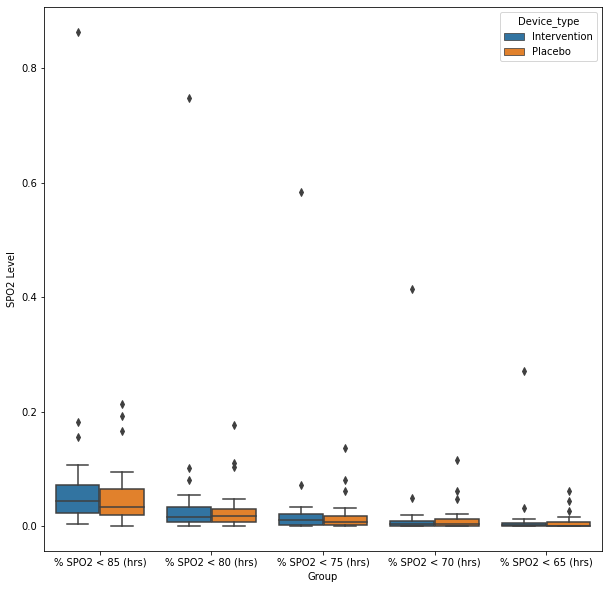

time: 419 ms (started: 2023-03-15 07:10:03 +00:00)


In [111]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import ttest_ind

plot_opts = {
    "cutoff_val": 5,
    "cutoff_type": "abs",
    "label_fontsize": "small",
    "label_rotation": 30,
}
# display (df_match)
df_melt = df_match.melt (id_vars = ['Device_type'],value_vars= spo2_col_percent_name_list, var_name = 'Group', value_name = 'SPO2 Level')
# display (df_melt)
# fig = plt.figure(10,10)
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df_melt, x = 'Group', y = 'SPO2 Level', hue = 'Device_type', ax=ax)


for col in spo2_col_percent_name_list:
    df = df_match
    placebo = df[df['Device_type']=='Placebo']
    intervention = df[df['Device_type']=='Intervention']
    print ("col: " + col)
    print(ttest_ind(placebo[col], intervention[col]))

#perform independent two sample t-test

# sns.stripplot(data=df_melt, x = 'Group', y = 'SPO2 Level', hue = 'Device_type', color = 'red')
# sns.stripplot(data=df_match, y = 'Time SPO2 < 85(hrs)', x = 'Device_type', color = 'red')




# df_beanplot = pd.DataFrame ()
# df_beanplot ['Baby of'] = df_match['Baby of']
# # df_beanplot['Intervention'] = df_match ['Time SPO2 < 85(hrs)'][df_match['Device_type'] == 'Intervention']
# df_beanplot['Intervention'] = df_match ['Time SPO2 < 85(hrs)'].where(df_match['Device_type'] == 'Intervention')
# df_beanplot['Placebo'] = df_match ['Time SPO2 < 85(hrs)'].where(df_match['Device_type'] == 'Placebo')
# # plt.boxplot(df_match['Time SPO2 < 85(hrs)'])
# # display (df_beanplot)
# df_intervention = pd.DataFrame ()
# df_intervention['Intervention'] = df_beanplot['Intervention']
# # df_intervention['Intervention'] = df_beanplot['Intervention'].dropna();
# # df_intervention = df_intervention.dropna ()
# # df_placebo = pd.DataFrame ()
# # df_intervention['Intervention'] = df_beanplot['Intervention']
# # df_intervention = df_intervention.dropna ()
# # sns.boxplot(data=df_match, y = 'Time SPO2 < 85(hrs)', x = 'Device_type')
# # sns.stripplot(data=df_match, y = 'Time SPO2 < 85(hrs)', x = 'Device_type', color = 'red')
# display (df_match)
# df_stack = df_match.stack()
# display (df_stack)
# # sns.boxplot(data=df_match, y = 'Time SPO2 < 85(hrs)', x = 'Device_type')

# # df_intervention = df_intervention [df_intervention['Intervention'].]
# # display (df_intervention)
# # plt.boxplot(df_intervention['Intervention'])

# # plt.show()
# # display (df_beanplot)
# # data = sm.load_pandas()
# # data = sm.load()

# # sm.graphics.beanplot (df_beanplot., ax=ax, labels = ['Intervention', 'Placebo'], plot_opts=plot_opts)

# # sm.graphics.beanplot(age, ax=ax, labels=labels, plot_opts=plot_opts)


In [ ]:
#### Calc Stats

# DRAFT - New Section

## ** Not Used Code**

In [ ]:
#@title
# #fname = "Report.pdf"
# with PdfPages(fname) as pdf:
#   print("This is a test of the print function")
#   pdf.savefig()

In [ ]:
#@title
# usage_pv_data_table = pd.pivot_table(data_table, index =['Data Date',"Settings Index"],
#                          aggfunc = 'count')

# print(usage_pv_data_table)
# usage_pv_data_table.to_csv('Usage_pv_data_table.csv',index=True)
# usage_pv_data_table.to_excel("Usage_pv_data_table.xlsx")





In [ ]:
#@title
pd.reset_option("all")
#df = stimulation_results_table_with_all_thresholds
#print(df)
#pivot = pd.pivot_table(stimulation_results_table_with_all_thresholds,
                       #values=["Status"], 
#                       index=['Status'])
                       #aggfunc={'Status': np.count,
                       # 'HR': [min, max, np.mean]})

#df = df.Status.value_counts()
#print(pivot)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# pd.set_option("precision", 4)

#print(df)


#print(len (stimulation_results_table_with_all_thresholds))
#filtered_results_table_all = df[(df["Status"]==129) | (df["Status"]==131)]
#print(len (filtered_results_table_all))

#data_table = filtered_results_table_all

# pivot = pd.pivot_table(data_table,
#                        values=['SPO2','HR'], 
#                        index=['Data Date'],
#                        aggfunc={'SPO2': np.mean,
#                         'HR': [min, max, np.mean]})

#print(pivot)
#filtered_results_table_all.to_csv("Filtered_Results_Table_All.csv")

# 129    91112
# 153    49477
# 131    32220



Want 
- Date
- Setting Index
- 



In [ ]:
#@title
# # !sudo apt-get install wkhtmltopdf
# # !yum install wkhtmltopdf
# !apt-get install wkhtmltopdf
# import pandas as pd 
# df_apnea_summary_table.to_html('HTMLTest.html')  

# import pdfkit 

# pdfkit.from_url('HTMLTest.html', 'HTMLTest.pdf')

In [ ]:
#@title
df = pd.DataFrame({'Col': [1,4,5,6,7],
                   'Col2': [1,4,5,6,7],
                   })
display (df)
New_Col = "Col3"
df [New_Col] = df["Col"] +1

display (df)
display (df[New_Col])

In [ ]:
#@title
# Create a pandas dataframe with demo data:
#!pip install -e git+https://github.com/mindee/doctr.git#egg=python-doctr[torch]
#!pip install weasyprint
!pip install django-weasyprint
import pandas as pd
demodata_csv = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv'
df = pd.read_csv(demodata_csv)

def dfToPDF (df):
  # Pretty print the dataframe as an html table to a file
  intermediate_html = '/tmp/intermediate.html'
  to_html_pretty(df,intermediate_html,'Iris Data')
  # if you do not want pretty printing, just use pandas:
  # df.to_html(intermediate_html)

  # Convert the html file to a pdf file using weasyprint
  import weasyprint
  out_pdf= '/tmp/demo.pdf'
  weasyprint.HTML(intermediate_html).write_pdf(out_pdf)

  # This is the table pretty printer used above:

def to_html_pretty(df, filename='/tmp/out.html', title=''):
    '''
    Write an entire dataframe to an HTML file
    with nice formatting.
    Thanks to @stackoverflowuser2010 for the
    pretty printer see https://stackoverflow.com/a/47723330/362951
    '''
    ht = ''
    if title != '':
        ht += '<h2> %s </h2>\n' % title
    ht += df.to_html(classes='wide', escape=False)

    with open(filename, 'w') as f:
         f.write(HTML_TEMPLATE1 + ht + HTML_TEMPLATE2)

HTML_TEMPLATE1 = '''
<html>
<head>
<style>
  h2 {
    text-align: center;
    font-family: Helvetica, Arial, sans-serif;
  }
  table { 
    margin-left: auto;
    margin-right: auto;
  }
  table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
  }
  th, td {
    padding: 5px;
    text-align: center;
    font-family: Helvetica, Arial, sans-serif;
    font-size: 90%;
  }
  table tbody tr:hover {
    background-color: #dddddd;
  }
  .wide {
    width: 90%; 
  }
</style>
</head>
<body>
'''

HTML_TEMPLATE2 = '''
</body>
</html>
'''

In [ ]:
#@title
# # PRINT TABLES & DATA
# from matplotlib.backends.backend_pdf import PdfPages
# #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
# #df_apnea_summary_table.plot()
# #dfToPDF (df)
# # fig = convertDataframeToFigure (apnea_summary_table)
# # pdf = PdfPages("foo.pdf")
# # pdf.savefig(fig, bbox_inches='tight')
# # pdf.close()
# # !pip install -c conda-forge python-pdfkit
# !pip3 install wkhtmltopdf
# !pip3 install pdfkit

# import pandas as pd
# import pdfkit as pdf
# import sqlite3

# # con=sqlite3.connect("baza.db")

# # df=pd.read_sql_query("select * from dobit", con)
# #df_apnea_summary_table.datetime = pd.to_datetime(apnea_summary_table.datetime)
# display(df_apnea_summary_table)

# df_apnea_summary_table.to_html('apnea_summary_table.html')
# nazivFajla='test.pdf'
# config = pdf.configuration(wkhtmltopdf=path_wkhtmltopdf)
# pdf.from_url('apnea_summary_table.html', nazivFajla, configuration=config)




In [ ]:
startpath = "/content/drive/MyDrive/Improve World Health/BEMPU Quality Management System Folder (Created by RN 211005)/3 - Product Specific Documents (TCF, etc)/BHPL-DHF – Design and Development/3)DHF-APNEBOOT_Rev 00/4. Design Verification _ Validation/DHF-01-28 - Design Validation Report/Product Validation/Clinical Validation/RCT ApneBoot/St. Johns Phase 1 Data/intervention/Sneha"
os.chdir(startpath)
file_name = '12log5 - made from mona xls file.csv'
file_name = 'Book2.csv'
df = pd.read_csv(file_name, header=None)

In [ ]:
!pwd
!ls